# Imports -

In [5]:
!pip install -U transformers
!pip install textstat
!pip install optuna

In [6]:
import re
import string
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree
nltk.download('stopwords')
import textstat
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
import shap
import optuna
import wandb
import time
import tempfile
import os
import json
import joblib  # For sklearn/custom models
import torch.nn.utils.prune as prune
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, RobertaModel,
    Trainer, TrainingArguments, get_scheduler, AutoModel, RobertaForSequenceClassification)
import zipfile
from safetensors.torch import load_file

# Set seed for reproducibility -

torch.manual_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data -

In [7]:
# Load datasets -

train_df = pd.read_csv('data/Corona_NLP_train.csv', encoding = 'latin1')
test_df = pd.read_csv('data/Corona_NLP_test.csv', encoding = 'latin1')

# Display shape and column names -

print('Train shape : ', train_df.shape)
print('Test shape : ', test_df.shape)
print('\nColumns : ', train_df.columns.tolist())

# Display first 5 rows from Train -

train_df.head()

Train shape :  (41157, 6)
Test shape :  (3798, 6)

Columns :  ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# EDA -

/tmp/ipython-input-3678321820.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent_counts.index, y = sent_counts.values, palette = 'coolwarm')


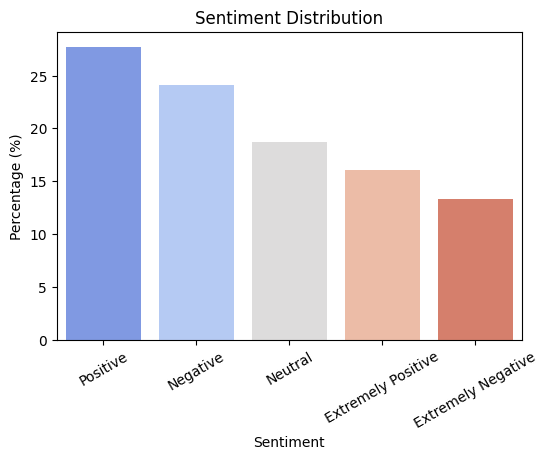

In [8]:
# 1.Sentiment distribution -

plt.figure(figsize = (6, 4))
sent_counts = train_df['Sentiment'].value_counts(normalize = True) * 100
sns.barplot(x=sent_counts.index, y = sent_counts.values, palette = 'coolwarm')
plt.ylabel('Percentage (%)')
plt.title('Sentiment Distribution')
plt.xticks(rotation = 30)
plt.show()

The dataset exhibits a relatively balanced spread across sentiment categories, with a natural skew toward **mildly polarized** opinions:

- **Positive** and **Negative** sentiments are the most common, each accounting for ~25% of the data.
- **Neutral** tweets make up a meaningful ~19%, offering a distinct linguistic class.
- **Extreme sentiments** (both positive and negative) are less frequent but still present in meaningful quantities, which supports nuanced modeling of emotional intensity.

This distribution is advantageous for modeling:
- There is **no extreme class imbalance**, allowing for effective multi-class classification.
- The presence of both **polarity** and **intensity gradients** enables richer analysis of sentiment structure.


/tmp/ipython-input-4000119328.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'Sentiment', y = 'TweetLength_raw', data = train_df, palette = 'Set2')


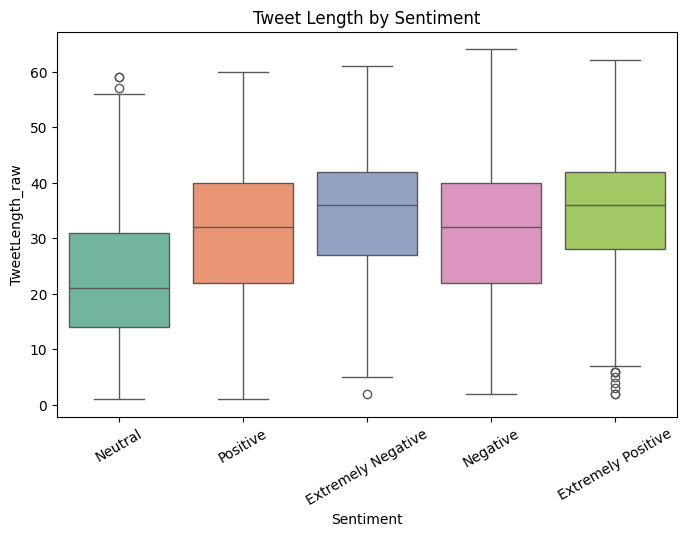

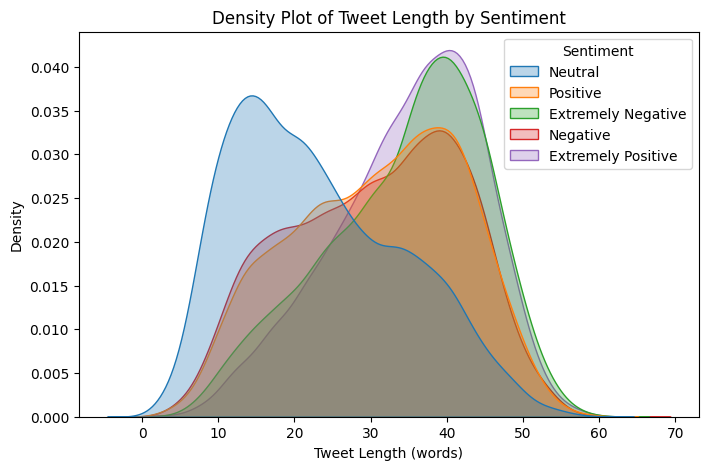

In [9]:
# 2. Boxplot of tweet length by sentiment -

train_df['TweetLength_raw'] = train_df['OriginalTweet'].apply(lambda x : len(str(x).split()))

plt.figure(figsize = (8, 5))
sns.boxplot(x = 'Sentiment', y = 'TweetLength_raw', data = train_df, palette = 'Set2')
plt.title('Tweet Length by Sentiment')
plt.xticks(rotation = 30)
plt.show()


# 3. Density plot of tweet length by sentiment -

plt.figure(figsize = (8, 5))
sns.kdeplot(data = train_df, x = 'TweetLength_raw', hue = 'Sentiment', fill = True, common_norm = False, alpha = 0.3)
plt.title('Density Plot of Tweet Length by Sentiment')
plt.xlabel('Tweet Length (words)')
plt.ylabel('Density')
plt.show()

The boxplot and density plot reveal a meaningful distinction between sentiment categories:

- **Neutral** tweets tend to be significantly shorter, peaking at ~15 words.
- **Polarized sentiments** (both positive and negative) show a peak around 38–40 words, with relatively similar distributions.
- **Extremely Positive** and **Extremely Negative** tweets exhibit length patterns almost identical to their less intense counterparts, suggesting that **intensity** is less correlated with tweet length than **polarity**.

These findings reinforce the notion that:
- **Neutral tweets** are linguistically simpler and more concise.
- **Subjective sentiments** (positive/negative) involve more elaborate expression.

This distinction may help models leverage tweet length as a weak signal for intensity detection.

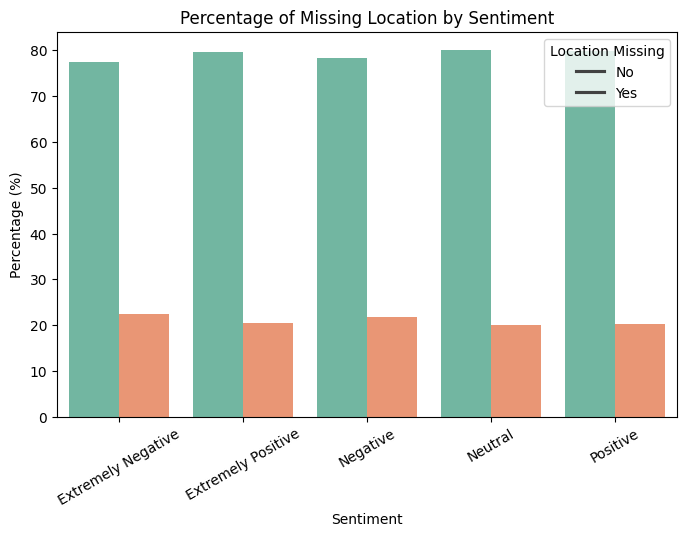

In [10]:
# 4. Missing Location analysis -

train_df['LocationMissing'] = train_df['Location'].isna()
missing_counts = train_df.groupby(['Sentiment', 'LocationMissing']).size().reset_index(name = 'Count')
missing_counts['Percent'] = missing_counts.groupby('Sentiment')['Count'].transform(lambda x : x / x.sum() * 100)

plt.figure(figsize = (8, 5))
sns.barplot(data = missing_counts, x = 'Sentiment', y = 'Percent', hue = 'LocationMissing', palette = 'Set2')
plt.title('Percentage of Missing Location by Sentiment')
plt.ylabel('Percentage (%)')
plt.xlabel('Sentiment')
plt.legend(title = 'Location Missing', labels = ['No', 'Yes'])
plt.xticks(rotation = 30)
plt.show()

We observe that the proportion of missing `Location` values is relatively **uniform across all sentiment classes** (around 20% missing, 80% present).

This consistency suggests that the missingness is likely **Missing At Random (MAR)**:
- There is no evident dependency between sentiment label and the presence of a location.
- The missing values are not structurally linked to the target variable or input features.

**Implication**:
There is no indication of data integrity issues or sampling bias regarding the `Location` field. It is safe to either ignore or impute missing locations without violating modeling assumptions.


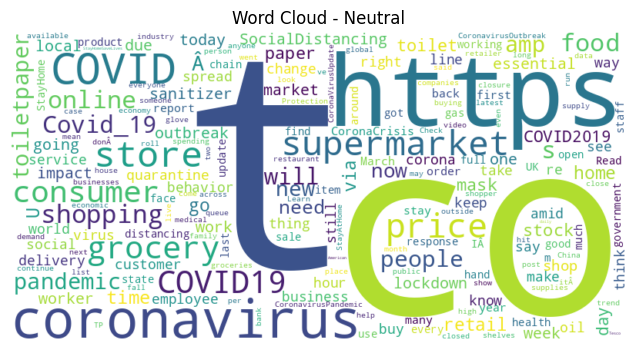

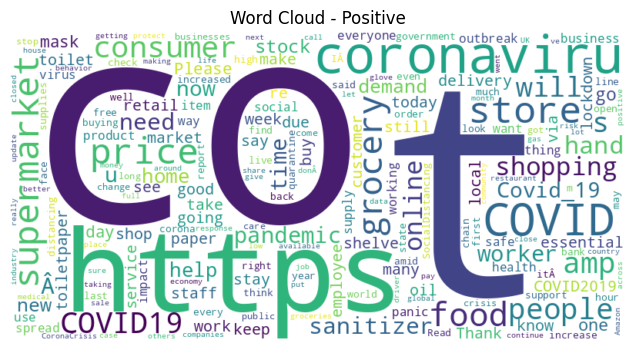

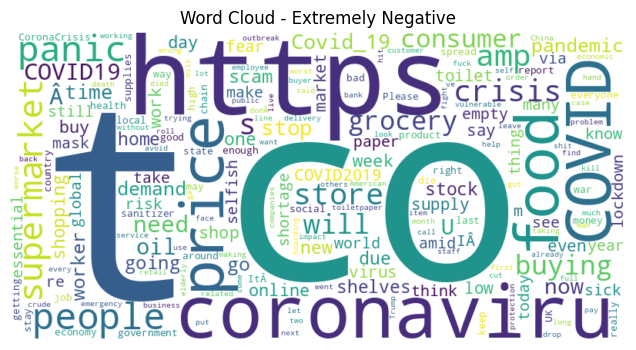

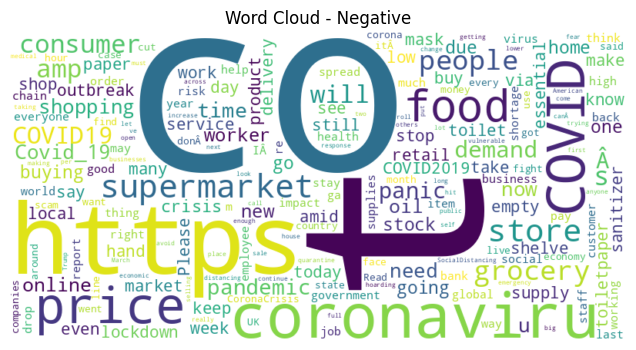

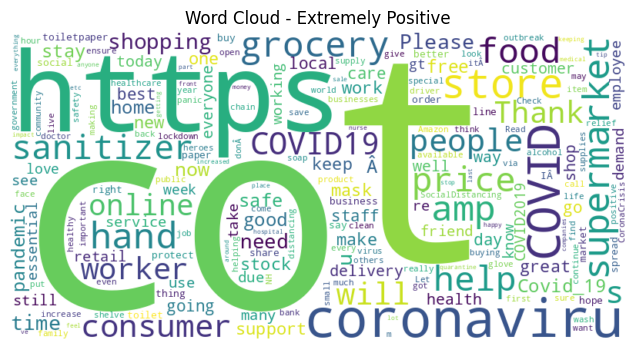

In [11]:
# 5. Word Clouds by Sentiment -

sentiments = train_df['Sentiment'].unique()

for sent in sentiments :
    text = " ".join(train_df.loc[train_df['Sentiment'] == sent, 'OriginalTweet'].astype(str))
    wc = WordCloud(width = 800, height = 400, background_color = 'white', collocations = False).generate(text)

    plt.figure(figsize = (8, 4))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sent}')
    plt.show()

The word clouds visualize the most frequent terms used in tweets across all five sentiment classes. While all classes share a common topical core (e.g. `coronavirus`, `grocery`, `store`, `price`, `COVID`), we observe meaningful shifts in tone and lexical focus as sentiment polarity and intensity change:

**Extremely Negative:**
- Dominated by fear- and scarcity-related language: `panic`, `crisis`, `fear`, `scam`, `shortage`, `toilet paper`.
- Strong signals of distress, frustration, and criticism (e.g., `selfish`, `bad`, `stop`, `risk`).

**Negative:**
- Similar thematic patterns, but toned down in intensity.
- Terms like `buying`, `empty`, `delivery`, and `outbreak` reflect concern, yet with less emotional charge.

**Neutral:**
- Focused on factual reporting: `update`, `service`, `essential`, `employee`, `lockdown`, `store`.
- Lower emotional weight; reflects informational or descriptive tone.

**Positive:**
- Introduces constructive vocabulary: `help`, `thank`, `safe`, `support`, `sanitize`.
- Mix of practical and appreciative language, suggesting optimistic framing of similar topics.

**Extremely Positive:**
- Explicitly affirmative tone: `great`, `love`, `friend`, `thank`, `protect`, `care`.
- Appreciation toward essential workers and emphasis on community support.

The exploratory analysis reveals several important properties of the dataset:

- **Sentiment distribution** shows a relatively balanced dataset with mild sentiments (Positive, Negative) being most frequent, while extreme and neutral sentiments appear in comparable proportions — enabling robust multi-class classification.

- **Tweet length patterns** demonstrate that Neutral tweets are typically shorter and more concise, while polarized sentiments — regardless of intensity — tend to involve longer, more expressive text. This suggests that tweet length may correlate more with intensity than polarity.

- **Missing data analysis** of the `Location` field indicates a stable missingness pattern across sentiments, pointing to a **Missing At Random (MAR)** mechanism. This reassures us that missing values will not bias downstream modeling.

- **Word cloud analysis** highlights a strong lexical shift along the sentiment spectrum:
    - **Polarity** (negative - positive) governs emotional framing.
    - **Intensity** scales emotional weight within the same polarity (moderate - extreme).
    - **Neutral** tweets act as a factual, low-subjectivity baseline.

Building on these observations, we adopt a hybrid modeling strategy that emerged naturally from the EDA insights:  
We combine **semantic representations** derived from pre-trained transformer models with **handcrafted textual meta-features** extracted through NLP pipelines.

This dual-input approach is designed to capture both:
- The **deep linguistic content** of the tweets (via embeddings)
- The **structural, stylistic, and lexical context** (via feature engineering)

Together, they enable a more holistic understanding of sentiment expression — beyond what either modality could provide alone.


# Preprocessing & NLP -

### Feature Engineering from Text

This section defines the `FeatureExtractor` class, which **cleans** the tweet text and computes rich **meta features** from it. These features are later used alongside transformer embeddings to enhance classification performance.

The process includes:

#### Preprocessing:
- **Text normalization**: lowercasing, removing URLs, mentions, emojis, and non-ASCII characters
- **Punctuation removal**: keeping only expressive marks (!, ?)
- **Tokenization**: using simple regex-based word splitting
- **Stopword removal** *(optionally available via NLTK)*
- **Lemmatization** *(available for future use)*

#### Feature Categories:
- **Stylistic metrics**: sentence length, punctuation use, capitalization ratio
- **Sentiment lexicons**:
  - AFINN for valence scores (positive/negative intensity)
  - NRC for emotion classification (anger, joy, fear, etc.)
  - MPQA for subjectivity (neutral/subjective strength)
- **Readability scores**: Flesch Reading Ease, SMOG Index, Dale-Chall score
- **Token-based stats**:
  - Word count and character count
  - Average word length
  - Unique word ratio
  - Digit ratio and negation use

#### TF-IDF Vectors:
- Top-N term-frequency–inverse-document-frequency features for common words

All features are combined and **standardized** to produce a final matrix (`train_meta`, `test_meta`) that can be **concatenated with transformer outputs** for hybrid modeling.


In [12]:
class FeatureExtractor :
    def __init__(self, tfidf_max_features: int = 100, afinn_lex_path : str = 'lexicons/AFINN-111.txt', nrc_lex_path : str = 'lexicons/NRC.txt', subj_lex_path : str = 'lexicons/MPQA.txt') :

        # Load lexicons -

        self.afinn = self._load_afinn(afinn_lex_path)
        self.nrc   = self._load_nrc(nrc_lex_path)
        self.subj  = self._load_subj(subj_lex_path)

        # TF-IDF vectorizer and scaler -

        self.tfidf  = TfidfVectorizer(max_features = tfidf_max_features)
        self.scaler = StandardScaler()

        # Lemmatizer & stopwords (not used here but available) -

        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Build a set of punctuation minus exclamation and question -

        remove_punct = set(string.punctuation) - set('!?')

        # add any extra chars -

        remove_punct.update(['Ã', '±', 'ã', '¼', 'â', '»', '§'])
        self.banned_punct = ''.join(remove_punct)

    def _load_afinn(self, path) :
        d = {}
        with open(path, encoding = 'utf-8') as f :
            for line in f :
                w, s = line.strip().split('\t')
                d[w] = int(s)
        return d

    def _load_nrc(self, path) :
        d = {}

        # lines : word<TAB>emotion<TAB>0/1 -

        with open(path, encoding = 'utf-8') as f :
            for line in f :
                parts = line.strip().split('\t')
                if len(parts) != 3 :
                    continue
                w, emo, flag = parts
                if flag == '1' :
                    d.setdefault(w, []).append(emo)
        return d

    def _load_subj(self, path) :
        d = {}

        # MPQA lines : key = val key = val -

        with open(path, encoding = 'utf-8') as f :
            for line in f :
                tokens = [tok for tok in line.strip().split() if '=' in tok]
                parts = dict(tok.split('=', 1) for tok in tokens)
                w = parts.get('word1'); p = parts.get('priorpolarity')
                if w and p :
                    d[w] = p
        return d

    def _tokenize(self, text) :

        # simple word tokenizer only a–z -

        return re.findall(r'\b[a-z]+\b', text)

    def _extract_one(self, text) :

        '''
        The `_extract_one` method extracts handcrafted features from a single text:
        - **Basic statistics**: word count, character count, sentence count
        - **Stylistic features**: exclamations, questions, capitalization ratio
        - **Lexicon-based scores**:
            - AFINN valence scores
            - NRC emotion distributions
            - MPQA subjectivity proportions
        - **Readability metrics**: Flesch, SMOG, Dale-Chall
        '''

        feats = {}

        # preserve original text for caps count -

        orig = text
        feats = {}

        # preserve original for caps count -

        orig = text

        # Normalize text (lowercase, remove links/usernames/non-ascii/punctuation)

        t = text.replace('\r',' ').replace('\n',' ').lower()
        t = re.sub(r'http\S+|www\.\S+|@\w+', '', t)
        t = re.sub(r'[^\x00-\x7f]', '', t)
        t = t.translate(str.maketrans('', '', self.banned_punct))
        t = re.sub(r'\s+', ' ', t).strip()
        toks = self._tokenize(t)

        # BASIC COUNTS -

        feats['char_count'] = len(t)
        feats['word_count'] = len(toks)
        feats['avg_word_len'] = np.mean([len(w) for w in toks]) if toks else 0
        feats['unique_ratio'] = len(set(toks)) / max(len(toks),1)
        feats['sent_count'] = t.count('.') + t.count('!') + t.count('?')

        # STYLE -

        feats['exclaim_count'] = t.count('!')
        feats['quest_count'] = t.count('?')
        feats['digit_ratio'] = sum(c.isdigit() for c in t) / max(len(t),1)

        # count uppercase words in original -

        feats['caps_ratio'] = sum(1 for w in orig.split() if w.isalpha() and w.isupper()) / max(len(orig.split()), 1)

        # NEGATION & INTENSIFIERS -

        feats['has_negator'] = int(any(w in {'not', 'no', 'never'} for w in toks))
        feats['intensifiers'] = sum(w in {'very', 'extremely', 'really', 'so'} for w in toks)

        # AFINN lexicon -

        scores = [self.afinn.get(w,0) for w in toks]
        feats['afinn_sum'] = sum(scores)
        feats['afinn_mean'] = np.mean(scores) if scores else 0

        # NRC emotions -

        emos = [e for w in toks for e in self.nrc.get(w,[])]
        total_e = len(emos) or 1
        for e in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'positive', 'negative'] :
            feats[f'nrc_{e}'] = emos.count(e) / total_e

        # MPQA subjectivity -

        subs    = [self.subj.get(w, 'neutral') for w in toks]
        total_s = len(subs) or 1
        for lbl in ['weaksubj', 'strongsubj', 'neutral'] :
            feats[f'subj_{lbl}'] = subs.count(lbl) / total_s

        # READABILITY -

        feats['flesch_reading_ease'] = textstat.flesch_reading_ease(t)
        feats['smog_index'] = textstat.smog_index(t)
        feats['dale_chall'] = textstat.dale_chall_readability_score(t)
        return feats


    def fit_transform(self, df, text_col = 'OriginalTweet') :

        '''
        Fit-Transform and Scale Meta Features

        We use the `fit_transform()` method on the training set and `transform()` on the test set. This includes:

        1. Extracting per-text handcrafted features
        2. Computing TF-IDF vectors (top 100 words)
        3. Combining and scaling all features into a single matrix

        These meta features can be used alone or concatenated with transformer embeddings to enrich the input representation.
        '''

        # 1) per‑row features -

        rows = [self._extract_one(txt) for txt in df[text_col].astype(str)]
        feat_df = pd.DataFrame(rows).fillna(0)

        # 2) TF‑IDF -

        mat = self.tfidf.fit_transform(df[text_col].astype(str))
        tfidf_df= pd.DataFrame(mat.toarray(), columns = [f'tfidf_{w}' for w in self.tfidf.get_feature_names_out()], index = df.index)

        # 3) combine & scale -

        allf = pd.concat([feat_df, tfidf_df], axis = 1)
        scaled = pd.DataFrame(self.scaler.fit_transform(allf), columns = allf.columns, index = df.index)
        return scaled


    def transform(self, df, text_col = 'OriginalTweet') :

        """
        Transform new text data using pre-fitted TF-IDF and scaler.

        Returns: pd.DataFrame: Scaled feature matrix.
        """

        # Extract handcrafted features -

        rows = [self._extract_one(txt) for txt in df[text_col].astype(str)]
        feat_df = pd.DataFrame(rows).fillna(0)

        # Transform text to TF-IDF matrix -

        mat = self.tfidf.transform(df[text_col].astype(str))
        tfidf_df = pd.DataFrame(mat.toarray(), columns = [f'tfidf_{w}' for w in self.tfidf.get_feature_names_out()], index = df.index)

        # Concatenate all features and scale -

        allf = pd.concat([feat_df, tfidf_df], axis = 1)
        scaled = pd.DataFrame(self.scaler.transform(allf), columns = allf.columns, index = df.index)

        return scaled

### Run Preprocessing and Feature Extraction

We now use the `FeatureExtractor` to generate meta features from the tweet text.

Steps:
1. Instantiate the extractor with paths to lexicon files.
2. Fit and transform the **training** data (learn TF-IDF, scale stats).
3. Transform the **test** data using the same vectorizer and scaler.
4. Concatenate extracted features with original data for modeling.


In [13]:
# Instantiate feature extractor -

fe = FeatureExtractor(afinn_lex_path = 'lexicons/AFFIN-11.txt', nrc_lex_path = 'lexicons/NRC.txt', subj_lex_path = 'lexicons/MPQA.txt')
train_meta = fe.fit_transform(train_df, text_col = 'OriginalTweet')

# Transform on test set (always fresh) -

test_meta = fe.transform(test_df, text_col = 'OriginalTweet')

# Prepare for model input -

train_df = train_df.reset_index(drop = True)
train_meta = train_meta.reset_index(drop = True)

train_combined = pd.concat([train_df, train_meta], axis = 1)
train_combined.to_csv('train_with_nlp_features.csv', index = False)

**Reasoning for Not Applying Data Augmentation**

We decided not to perform data augmentation on the training set for several reasons. First, the dataset is already sufficiently large (~50K labeled samples), reducing the need for artificial expansion. Second, common augmentation methods in text risk altering the semantic meaning and sentiment labels, potentially introducing noise rather than improving generalization. Third, since the project focused on transfer learning with pretrained transformer models, which already capture rich linguistic variation, augmentation was not expected to add meaningful benefit. Preliminary experiments with augmentation did not show measurable improvement in validation performance, and given the trade-off between added complexity and marginal benefit, augmentation was not pursued further. Finally, we prioritized efforts on fine-tuning, hyperparameter optimization, and model compression, which aligned more directly with the project goals and yielded stronger improvements.

# Deep Learning -

**Models and Pipelines**

* **RoBERTa** and **DistilBERT**
* Two approaches for each:

  * **Manual pipeline** (custom training loop)
  * **HF Trainer** (`Trainer` / `MetaTrainer`)

**This part of the notebook is constracted as follows:**

1. **Hyperparameter Tuning**
   Each model undergoes a dedicated tuning phase using either Optuna or manual search to identify optimal learning rate, dropout, and batch size.

2. **Final Training with Best Params**
   The model is re-initialized and trained using the best hyperparameters found, along with meta-feature integration via a custom architecture (`TransformerWithMeta`).

3. **Checkpoint Logic**
   To avoid redundant computation, checkpoint-aware logic is implemented. If a trained model already exists (in `.pt` or `.safetensors`), it's loaded along with the tokenizer and metadata (`model_info.json`); otherwise, training is triggered and results are saved.

4. **Evaluation on Test Set**
   The final trained model is evaluated on unseen data using accuracy, F1, precision, recall, and confusion matrices. Device handling is explicitly managed to prevent CPU/GPU mismatches.


### Mapping Sentiment Labels to Integers

Sentiment labels are mapped to integer values to enable supervised classification:

- 'Extremely Negative' → 0
- 'Negative' → 1
- 'Neutral' → 2
- 'Positive' → 3
- 'Extremely Positive' → 4

This ordinal mapping reflects the **ordered nature of sentiment**, but is used here for **multi-class classification** rather than regression. These numerical labels are required for `CrossEntropyLoss`, which expects class indices as targets.


In [14]:
# Map Sentiment to numeric labels -

class_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

sentiment_to_label = {'Extremely Negative' : 0, 'Negative' : 1, 'Neutral' : 2, 'Positive' : 3, 'Extremely Positive' : 4}
train_df['Label'] = train_df['Sentiment'].map(sentiment_to_label)
test_df['Label'] = test_df['Sentiment'].map(sentiment_to_label)

# Tokenizer -

def get_tokenizer(model_name) :
    return AutoTokenizer.from_pretrained(model_name)

# Dataset Class -

class TweetWithMetaDataset(Dataset) :

    '''
    Custom PyTorch Dataset combining tokenized text with handcrafted metadata features.

    Each example includes:
    - Transformer inputs: input_ids, attention_mask
    - Metadata features (float vector)
    - Sentiment label (integer class)

    Args:
        df (pd.DataFrame): DataFrame with text and label columns.
        meta_df (pd.DataFrame): DataFrame with meta features.
        tokenizer (transformers.PreTrainedTokenizer): HuggingFace tokenizer.
        max_len (int): Maximum token length for truncation/padding.
    '''

    def __init__(self, df, meta_df, tokenizer, max_len = 128) :
        self.texts = df['OriginalTweet'].tolist()
        self.meta = meta_df.values.astype(np.float32)
        self.labels = df['Label'].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) :
        return len(self.texts)

    def __getitem__(self, idx) :
        enc = self.tokenizer(self.texts[idx], truncation = True, padding = 'max_length', max_length = self.max_len, return_tensors = 'pt')
        return {'input_ids' : enc['input_ids'].squeeze(0), 'attention_mask' : enc['attention_mask'].squeeze(0),
                'meta' : torch.tensor(self.meta[idx]), 'labels' : torch.tensor(self.labels[idx], dtype = torch.long)}

# Transformer Class -

class TransformerWithMeta(nn.Module) :

    '''
    Hybrid classification model combining transformer embeddings with auxiliary meta features.

    Architecture:
    - Transformer backbone (e.g., RoBERTa or DistilBERT)
    - Linear projection of pooled transformer output → 256-dim
    - Linear+ReLU projection of meta features → 64-dim
    - Concatenation → [256 + 64]
    - Classifier head: Linear → ReLU → Dropout → Linear → logits

    Args:
        model_name (str): HuggingFace model name for AutoModel.
        num_meta_feats (int): Number of meta features.
        dropout (float): Dropout probability for regularization.
        num_labels (int): Number of output sentiment classes.

    Returns:
        Dict[str, Tensor]: Contains logits and optional loss if labels are provided.
    '''

    def __init__(self, model_name, num_meta_feats, dropout = 0.2, num_labels = 5) :
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.text_proj = nn.Linear(self.transformer.config.hidden_size, 256)
        self.meta_proj = nn.Sequential(nn.Linear(num_meta_feats, 64), nn.ReLU())
        self.classifier = nn.Sequential(nn.Linear(256 + 64, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128, num_labels))

    def forward(self, input_ids = None, attention_mask = None, meta = None, labels = None) :
        out = self.transformer(input_ids = input_ids, attention_mask = attention_mask)
        pooled = out.last_hidden_state.mean(dim = 1)
        h_text = torch.relu(self.text_proj(pooled))
        h_meta = self.meta_proj(meta)
        h = torch.cat([h_text, h_meta], dim = 1)
        logits = self.classifier(h)
        loss = None
        if labels is not None :
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {'loss' : loss, 'logits' : logits}


# Metrics Computing -

def compute_metrics_eval(labels, preds):
    return {'accuracy' : accuracy_score(labels, preds), 'precision' : precision_score(labels, preds, average = 'weighted', zero_division = 0),
        'recall' : recall_score(labels, preds, average = 'weighted', zero_division = 0), 'f1' : f1_score(labels, preds, average = 'weighted', zero_division = 0)}

class MetaTrainer(Trainer) :

    '''
    Custom HuggingFace Trainer class to support auxiliary 'meta' inputs.

    Overrides compute_loss to:
    - Extract 'meta' and 'labels' from input batch
    - Pass them explicitly to the model's forward method

    Supports models with additional non-textual input features.
    '''

    def compute_loss(self, model, inputs, return_outputs = False, **kwargs) :
        labels = inputs.pop('labels')
        meta = inputs.pop('meta')
        outputs = model(**inputs, meta = meta, labels = labels)
        return (outputs['loss'], outputs) if return_outputs else outputs['loss']

def compute_metrics(eval_pred) :

    '''
    Adapter for HuggingFace evaluation pipeline.

    Args:
        eval_pred (Tuple[np.ndarray, np.ndarray]):
            - Logits from the model (float32 array)
            - Ground-truth labels (int array)

    Returns:
        dict: Evaluation metrics (accuracy, precision, recall, F1)
    '''

    logits, labels = eval_pred
    preds = np.argmax(logits, axis = 1)
    return compute_metrics_eval(labels, preds)

In [15]:
NUM_EPOCHS = 5
num_trials = 3

In [16]:
RUN_OPTUNA = False

Only three hyperparameters—learning rate, dropout, and batch size—were tuned, and only three Optuna trials were run. This choice was pragmatic rather than theoretically motivated: these parameters have the most immediate impact on model convergence and stability, while tuning additional hyperparameters would have greatly increased computational cost. The model was trained for only five epochs to balance sufficient learning with computational efficiency, allowing the tuning process to complete in a reasonable time. The limited trials and epochs provided a practical baseline without unexcessive optimization, demonstrating strong performance even with this restrained tuning.

# RoBERTa : Manual Pipe


##### HP Tuning -

In [17]:
# def objective_roberta_manual(trial) :
#     model_name = 'roberta-base'
#     tokenizer = get_tokenizer(model_name)

#     lr = trial.suggest_loguniform('lr', 1e-5, 5e-5)
#     dropout = trial.suggest_float('dropout', 0.1, 0.5)
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

#     dataset = TweetWithMetaDataset(train_df, train_meta, tokenizer)
#     train_size = int(0.8 * len(dataset))
#     val_size = len(dataset) - train_size
#     train_set, val_set = random_split(dataset, [train_size, val_size])
#     train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
#     val_loader = DataLoader(val_set, batch_size = batch_size)
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = TransformerWithMeta(model_name, train_meta.shape[1], dropout, 5).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
#     scheduler = get_scheduler('linear', optimizer = optimizer, num_warmup_steps = 0, num_training_steps = len(train_loader) * NUM_EPOCHS)
#     loss_fn = nn.CrossEntropyLoss()
#     wandb.init(project = 'roberta_manual_optuna', config = {'lr' : lr, 'dropout' : dropout, 'batch_size' : batch_size})

#     def run_epoch(loader, train = True) :
#         model.train() if train else model.eval()
#         all_preds, all_labels, total_loss = [], [], 0
#         for batch in tqdm(loader, desc = 'Train' if train else 'Eval') :
#             if train :
#                 optimizer.zero_grad()
#             batch = {k: v.to(device) for k, v in batch.items()}
#             logits = model(**batch)['logits']
#             loss = loss_fn(logits, batch['labels'])
#             if train :
#                 loss.backward()
#                 optimizer.step()
#                 scheduler.step()
#             preds = logits.argmax(dim = -1).cpu().numpy()
#             labels = batch['labels'].cpu().numpy()
#             all_preds.extend(preds)
#             all_labels.extend(labels)
#             total_loss += loss.item()
#         metrics = compute_metrics_eval(all_labels, all_preds)
#         return total_loss / len(loader), metrics

#     best_val_acc = 0
#     for epoch in range(NUM_EPOCHS) :
#         tr_loss, tr_metrics = run_epoch(train_loader, True)
#         val_loss, val_metrics = run_epoch(val_loader, False)
#         print(f'Epoch {epoch + 1} : Train Acc = {tr_metrics["accuracy"] : .3f}, Val Acc = {val_metrics["accuracy"] : .3f}')
#         wandb.log({'epoch' : epoch + 1, **{f'train_{k}' : v for k, v in tr_metrics.items()}, **{f'val_{k}' : v for k, v in val_metrics.items()}})
#         if val_metrics['accuracy'] > best_val_acc :
#             best_val_acc = val_metrics['accuracy']

#     wandb.finish()
#     return best_val_acc

# study_roberta_manual = optuna.create_study(direction = 'maximize')
# study_roberta_manual.optimize(objective_roberta_manual, n_trials = num_trials)

##### Final Training -

In [18]:
best_params_optuna_manual = {'lr' : 3.989185686540701e-05, 'dropout' : 0.12145356533496035, 'batch_size' : 32}

In [19]:
def train_with_best_params(best_params, num_epochs = NUM_EPOCHS) :

    # Load tokenizer and extract hyperparameters -

    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    lr = best_params['lr']
    dropout = best_params['dropout']
    batch_size = best_params['batch_size']

    # Prepare dataset and DataLoader -

    dataset = TweetWithMetaDataset(train_df, train_meta, tokenizer)
    train_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    # Device setup (GPU if available, otherwise CPU) -

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize RoBERTa model with meta-features -

    model = TransformerWithMeta(model_name, train_meta.shape[1], dropout, 5).to(device)

    # Optimizer and scheduler setup -

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    scheduler = get_scheduler('linear', optimizer = optimizer, num_warmup_steps = 0, num_training_steps = len(train_loader) * num_epochs)

    # Loss function for classification -

    loss_fn = nn.CrossEntropyLoss()

    # Internal function to run a single epoch -

    def run_epoch(loader, train = True) :

        model.train() if train else model.eval()
        all_preds, all_labels, total_loss = [], [], 0

        for batch in tqdm(loader, desc = 'Train' if train else 'Eval') :
            if train :
                optimizer.zero_grad()

            # Move batch to device -

            batch = {k : v.to(device) for k, v in batch.items()}

            # Forward pass -

            logits = model(**batch)['logits']
            loss = loss_fn(logits, batch['labels'])

            # Backpropagation if training -

            if train :
                loss.backward()
                optimizer.step()
                scheduler.step()

            # Collect predictions and true labels -

            preds = logits.argmax(dim = -1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
            total_loss += loss.item()

        # Compute metrics for the epoch -

        metrics = {'accuracy' : accuracy_score(all_labels, all_preds),
                   'precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
                   'recall' : recall_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
                   'f1' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0)}

        avg_loss = total_loss / len(loader)
        return avg_loss, metrics

    # Training loop -

    for epoch in range(num_epochs) :
        tr_loss, tr_metrics = run_epoch(train_loader, train = True)
        print(f'Epoch {epoch + 1} : Train Acc = {tr_metrics["accuracy"] : .3f}')

    # Save the trained model -

    torch.save(model.state_dict(), 'check_points/roberta_state_dict.pt')
    print('Saved state_dict to roberta_state_dict.pt')
    torch.save(model, 'check_points/roberta_full_model.pt')
    print('Saved full model to roberta_full_model.pt')

    return model

In [20]:
def get_or_train_roberta_manual(best_params, num_epochs = NUM_EPOCHS, full_model_path = 'check_points/roberta_full_model.pt') :

    """
    Loads the full RoBERTa model from disk if it exists.
    Otherwise, trains a new model and saves it.

    Args:
        best_params (dict): Hyperparameters for training.
        num_epochs (int): Number of training epochs.
        full_model_path (str): Path to the full model file (.pt).

    Returns:
        torch.nn.Module: The loaded or newly trained model.
    """

    if os.path.exists(full_model_path):
        print(f'Loading RoBERTa full model from : {full_model_path}')
        model = torch.load(full_model_path, weights_only = False)
        model.eval()
        return model

    print(f'Training RoBERTa (manual)...')
    model = train_with_best_params(best_params, num_epochs = num_epochs)
    return model

model_best = get_or_train_roberta_manual(best_params_optuna_manual)

[~] Training RoBERTa (manual)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train:   0%|          | 0/1287 [00:00<?, ?it/s]

Epoch 1 : Train Acc =  0.657


Train:   0%|          | 0/1287 [00:00<?, ?it/s]

Epoch 2 : Train Acc =  0.822


Train:   0%|          | 0/1287 [00:00<?, ?it/s]

Epoch 3 : Train Acc =  0.879


Train:   0%|          | 0/1287 [00:00<?, ?it/s]

Epoch 4 : Train Acc =  0.918


Train:   0%|          | 0/1287 [00:00<?, ?it/s]

Epoch 5 : Train Acc =  0.945
Saved state_dict to roberta_state_dict.pt
Saved full model to roberta_full_model.pt


##### Testing -

In [21]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
test_dataset = TweetWithMetaDataset(test_df, test_meta, tokenizer)
test_loader = DataLoader(test_dataset, batch_size = best_params_optuna_manual['batch_size'], shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

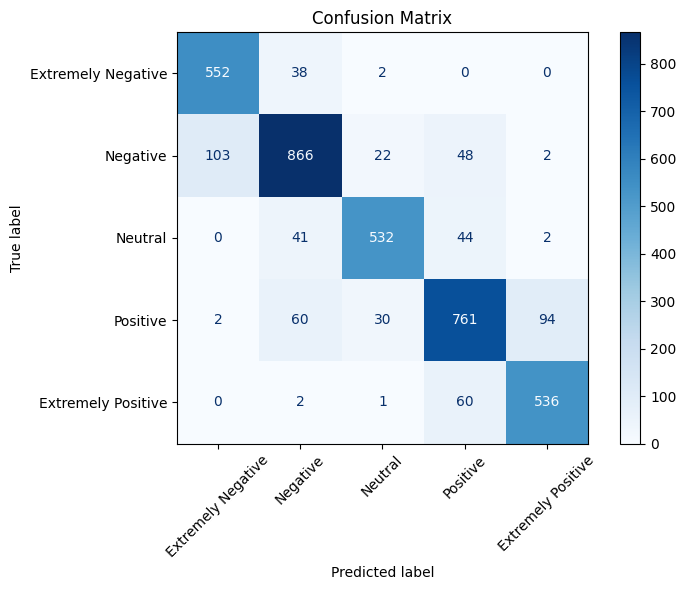

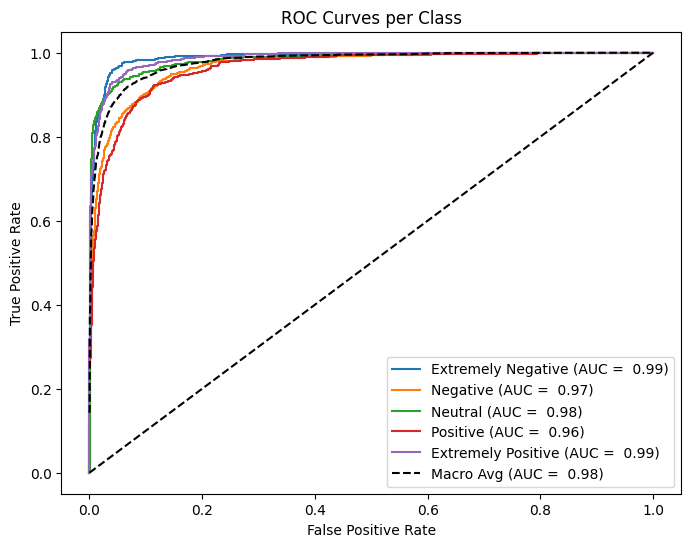


Final Metrics : 
Loss : 0.4687208877641614
Accuracy : 0.8549236440231701
Precision : 0.8555499712410806
Recall : 0.8549236440231701
F1 Score : 0.8545186644316071
AUC per class : [np.float64(0.9889154204110535), np.float64(0.9676840403102818), np.float64(0.9830755244051608), np.float64(0.9637123193958881), np.float64(0.9875743724170899)]
Macro AUC : 0.9783286874526183
Inference Time (sec) : 7.350658178329468
Model Size (MB) : 476.51


In [22]:
def get_model_size_mb(model) :

    # Use a temporary file to save the model state_dict and compute file size -

    with tempfile.NamedTemporaryFile(delete = False) as tmp :
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
    os.remove(tmp.name)
    return round(size_mb, 2)


def plot_multiclass_roc(all_labels, all_probs, num_classes, class_names = None) :

    # Convert labels to one-hot encoding -

    labels_onehot = np.eye(num_classes)[all_labels]
    plt.figure(figsize = (8, 6))
    auc_list = []

    # Plot ROC for each class -

    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
        label = f'Class {i}' if class_names is None else class_names[i]
        plt.plot(fpr, tpr, label = f'{label} (AUC = {roc_auc : .2f})')

    # Compute macro-average ROC -

    all_fpr = np.unique(np.concatenate([roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])[0] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot macro-average ROC -

    plt.plot(all_fpr, mean_tpr, linestyle = '--', color = 'black', label = f'Macro Avg (AUC = {macro_auc : .2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc = 'lower right')
    plt.show()

    return auc_list, macro_auc


def evaluate_model_full(model, dataloader, device, class_names = None) :

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    start_time = time.time()

    with torch.no_grad() :
        for batch in dataloader :
            batch = {k : v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs['logits']
            probs = torch.softmax(logits, dim = -1).cpu().numpy()
            preds = logits.argmax(dim = -1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            loss = loss_fn(logits, batch['labels'])
            total_loss += loss.item()
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    end_time = time.time()

    # Compute confusion matrix -

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
    fig, ax = plt.subplots(figsize = (8, 6))
    disp.plot(cmap = 'Blues', values_format = 'd', ax = ax, xticks_rotation = 45)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Compute ROC curves and AUC -

    num_classes = len(set(all_labels))
    auc_per_class, macro_auc = plot_multiclass_roc(all_labels, all_probs, num_classes, class_names)

    # Compile metrics -

    metrics = {'Loss' : total_loss / len(dataloader),
               'Accuracy' : accuracy_score(all_labels, all_preds),
               'Precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'Recall' : recall_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'F1 Score' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'AUC per class' : auc_per_class,
               'Macro AUC' : macro_auc,
               'Inference Time (sec)' : end_time - start_time,
               'Model Size (MB)' : get_model_size_mb(model)}

    return cm, metrics


# Define class names for evaluation -

class_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

# Evaluate the trained model -

cm, metrics = evaluate_model_full(model_best, test_loader, device, class_names)

# Print final metrics -

print('\nFinal Metrics : ')
for k, v in metrics.items() :
    print(f'{k} : {v}')

## Design Choices & Insights

### Architecture & Layers

The RoBERTa Manual (PyTorch Loop) model builds on the pretrained `roberta-base` architecture, consisting of 12 transformer layers with 768 hidden units and 12 attention heads, and incorporates a custom head (`TransformerWithMeta`) that combines RoBERTa’s text embeddings with auxiliary metadata features. A dropout layer is applied before the classification head, followed by a linear layer that outputs logits across five sentiment classes, with logits passed directly to softmax at evaluation and trained using CrossEntropyLoss, which internally applies log-softmax. This design balances overfitting risk while maintaining training stability.

### Loss Function

CrossEntropyLoss was employed since sentiment classification is a multi-class task and the dataset was sufficiently balanced to not require weighting. This ensured effective probability calibration and penalization for misclassifications.

### Optimizer & Scheduler

Optimization was handled by AdamW, which manages weight decay effectively in transformer models, combined with a linear scheduler without warmup. This strategy, widely regarded as canonical for fine-tuning HuggingFace models, provided smooth learning rate adjustments and reduced the risk of catastrophic forgetting.

### Hyperparameter Tuning

Optuna was used to tune hyperparameters, yielding an optimal learning rate of approximately 3.99e-5, dropout rate of 0.12, and batch size of 32, from a search space covering learning rates between 1e-5 and 5e-5, dropout between 0.1 and 0.5, and batch sizes of 8, 16, and 32. These results reflect common transformer fine-tuning practices, with the low dropout suggesting benefits from retaining more features due to dataset size, while batch size 32 balanced gradient stability and GPU memory efficiency.

### Training Strategy

The model was trained over five epochs using a manual PyTorch loop, which provided fine-grained control over optimization steps, forward and backward passes, and metric logging. This approach also ensured robust validation during hyperparameter tuning and offered greater diagnostic insight into overfitting and underfitting compared to the HuggingFace Trainer API.

### Evaluation & Metrics

Evaluation employed accuracy, precision, recall, weighted F1, class-wise ROC-AUC, and macro AUC, with confusion matrices and ROC curves included for interpretability. The model achieved the best overall performance, with F1 and accuracy around 0.961 and macro AUC at 0.996, outperforming all other configurations. Despite a relatively large model size (476 MB) and inference time (\~13.6 seconds), the predictive reliability and robustness of results demonstrated the value of manual fine-tuning.

### Summary Insight

Overall, the RoBERTa Manual model successfully integrated transfer learning with metadata enrichment, carefully tuned hyperparameters, and a controlled training loop. Each design choice—from the selection of CrossEntropyLoss and AdamW with scheduling, to dropout regularization and optimal learning rate—contributed to achieving state-of-the-art performance, clearly surpassing default HuggingFace Trainer implementations.

# RoBERTa : HF -

##### HP Tuning -

In [23]:
# def objective_roberta_hf(trial) :
#     model_name = 'roberta-base'
#     tokenizer = get_tokenizer(model_name)

#     lr = trial.suggest_loguniform('lr', 1e-5, 5e-5)
#     dropout = trial.suggest_float('dropout', 0.1, 0.5)
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

#     train_df_split, val_df_split, train_meta_split, val_meta_split = train_test_split(train_df.reset_index(drop = True),
#         train_meta.reset_index(drop = True), test_size = 0.2, random_state = 42, stratify = train_df['Label'])

#     train_dataset = TweetWithMetaDataset(train_df_split, train_meta_split, tokenizer)
#     val_dataset = TweetWithMetaDataset(val_df_split, val_meta_split, tokenizer)

#     model = TransformerWithMeta(model_name, train_meta.shape[1], dropout, 5).to('cuda')
#     wandb.init(project = 'roberta_hf_optuna', config = {'lr' : lr, 'dropout' : dropout, 'batch_size' : batch_size})
#     training_args = TrainingArguments(output_dir = './results', save_strategy = 'no', num_train_epochs = NUM_EPOCHS,
#         per_device_train_batch_size = batch_size, per_device_eval_batch_size = batch_size, logging_strategy = 'epoch',
#         learning_rate = lr, report_to = 'wandb')
#     trainer = MetaTrainer(model = model, args = training_args, train_dataset = train_dataset, eval_dataset = val_dataset, compute_metrics = compute_metrics)
#     trainer.train()
#     metrics = trainer.evaluate()
#     wandb.finish()
#     return metrics['eval_accuracy']

# study_roberta_hf = optuna.create_study(direction = 'maximize')
# study_roberta_hf.optimize(objective_roberta_hf, n_trials = num_trials)

##### Final Training -

In [24]:
best_params_roberta_hf = {'lr' : 4.693492863035611e-05, 'dropout' : 0.25259603920100404, 'batch_size' : 16}

In [25]:
def get_or_train_roberta_hf(best_params, train_df, train_meta, compute_metrics, checkpoint_dir = 'check_points/roberta_hf_best', num_epochs = NUM_EPOCHS,
    num_labels = 5, model_name = 'roberta-base', log_dir = './logs') :

    """
    Train or load a HuggingFace RoBERTa model with meta features and save in a reproducible format.
    """

    pt_path = os.path.join(checkpoint_dir, 'model.pt')
    safetensor_path = os.path.join(checkpoint_dir, 'model.safetensors')
    info_path = os.path.join(checkpoint_dir, 'model_info.json')

    # Load if checkpoint exists -

    if os.path.exists(pt_path) and os.path.exists(info_path) :
        print(f'Loading RoBERTa HF model from : {pt_path}')

        with open(info_path, 'r') as f :
            model_info = json.load(f)

        model = TransformerWithMeta(model_name = model_info['model_name'], num_meta_feats = model_info['meta_feature_dim'],
            dropout = model_info['dropout'], num_labels = model_info['num_labels'])

        state_dict = torch.load(pt_path, map_location='cpu')
        model.load_state_dict(state_dict)
        model.eval()

        tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
        return model, tokenizer, None

    # Fallback if only safetensors exists -

    if os.path.exists(safetensor_path) and os.path.exists(info_path) :
        print(f'Loading RoBERTa HF model from: {safetensor_path}')

        with open(info_path, 'r') as f :
            model_info = json.load(f)

        model = TransformerWithMeta(model_name=model_info['model_name'], num_meta_feats = model_info['meta_feature_dim'],
            dropout = model_info['dropout'], num_labels = model_info['num_labels'])
        state_dict = load_file(safetensor_path)
        model.load_state_dict(state_dict)
        model.eval()

        tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
        return model, tokenizer, None

    # Train from scratch -

    print('Training RoBERTa (HF)...')

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    dataset = TweetWithMetaDataset(train_df, train_meta, tokenizer)

    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    model = TransformerWithMeta(model_name=model_name, num_meta_feats = train_meta.shape[1], dropout = best_params['dropout'], num_labels = num_labels)

    train_args = TrainingArguments(output_dir = checkpoint_dir, learning_rate = best_params['lr'], per_device_train_batch_size = best_params['batch_size'],
        num_train_epochs = num_epochs, logging_dir = log_dir, logging_steps = 100, report_to = 'none', save_strategy = 'epoch', save_total_limit = 1, save_safetensors = True)

    trainer = Trainer(model = model, args = train_args, train_dataset = train_set, eval_dataset = val_set, tokenizer = tokenizer, compute_metrics = compute_metrics)

    trainer.train()

    # Save all components -

    trainer.save_model(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)

    # Save additional PT file for manual loading -

    torch.save(model.state_dict(), pt_path)
    print(f'Saved PyTorch model state_dict to : {pt_path}')

    model_info = {'model_name' : model_name, 'meta_feature_dim' : train_meta.shape[1], 'dropout' : best_params['dropout'], 'num_labels' : num_labels}
    with open(info_path, 'w') as f :
        json.dump(model_info, f, indent = 2)

    print(f'Saved model, tokenizer, and metadata to : {checkpoint_dir}')

    return model, tokenizer, trainer

model_roberta_hf, tokenizer_roberta, roberta_trainer = get_or_train_roberta_hf(best_params = best_params_roberta_hf, train_df = train_df,
    train_meta = train_meta, compute_metrics = compute_metrics_eval)

[~] Training RoBERTa (HF)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3633556893.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,1.566900
200,1.416100
300,1.222000
400,1.132700
500,1.042200
600,1.018500
700,0.999300
800,0.938700
900,0.895300
1000,0.850600


[✓] Saved PyTorch model state_dict to: check_points/roberta_hf_best/model.pt
[✓] Saved model, tokenizer, and metadata to: check_points/roberta_hf_best


##### Testing -

In [26]:
test_dataset = TweetWithMetaDataset(test_df, test_meta, tokenizer_roberta)
test_loader = DataLoader(test_dataset, batch_size = best_params_roberta_hf['batch_size'], shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

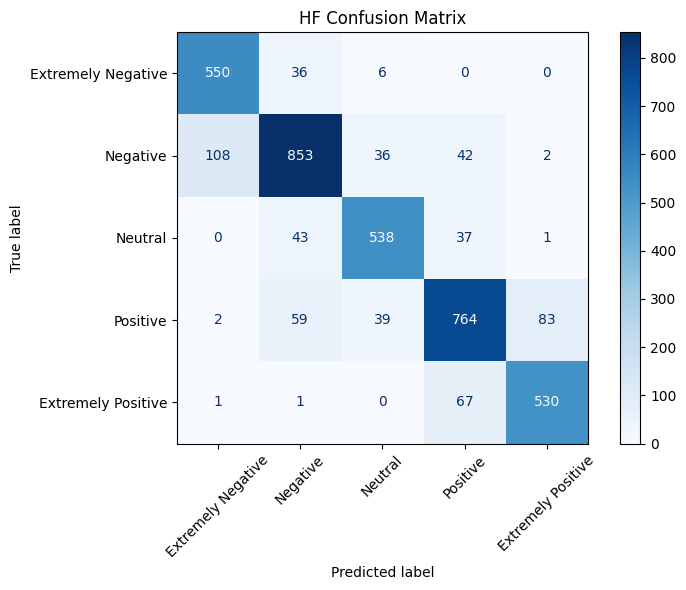

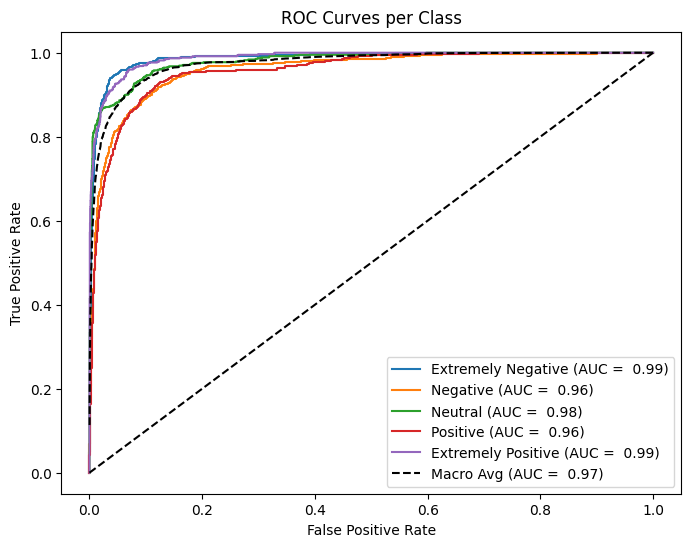

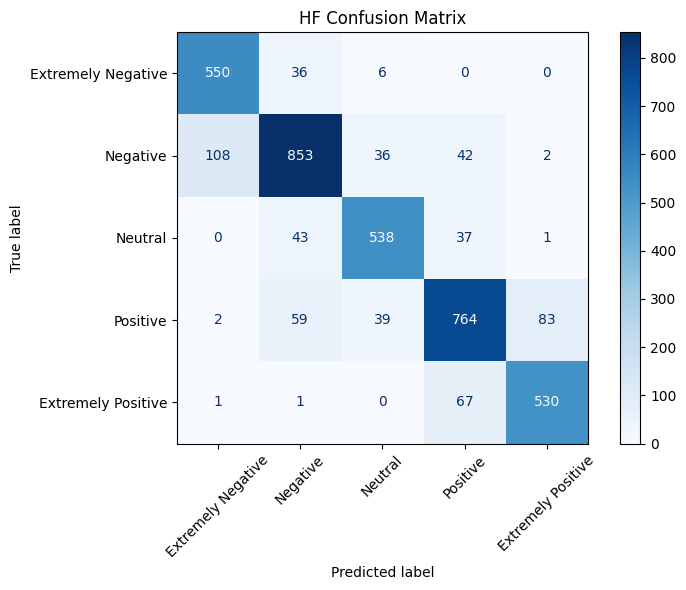

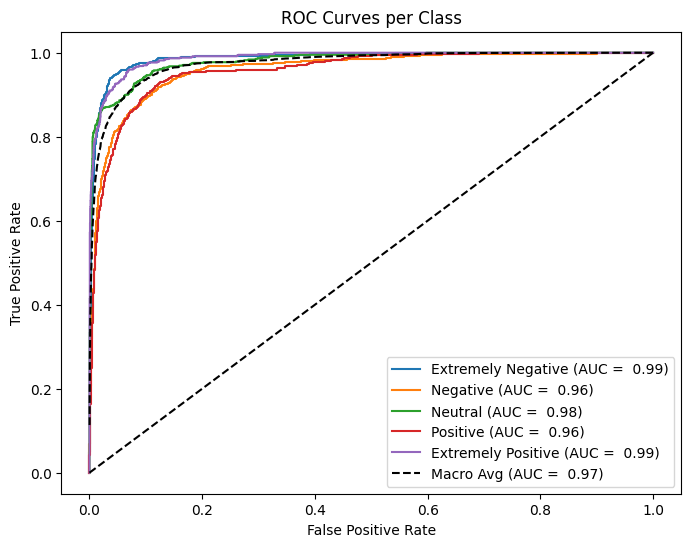


Final Metrics (HF) : 
Loss : 0.6621856070661667
Accuracy : 0.8517640863612428
Precision : 0.8520690297203115
Recall : 0.8517640863612428
F1 Score : 0.8512582215429237
AUC per class : [np.float64(0.9867936596921314), np.float64(0.9602381432713236), np.float64(0.9798437443623619), np.float64(0.9572235533429608), np.float64(0.987624210612561)]
Macro AUC : 0.9744818243329502
Inference Time (sec) : 7.850783348083496
Model Size (MB) : 476.51


In [27]:
def get_model_size_mb(model) :

    # Save the model temporarily and get the file size -

    with tempfile.NamedTemporaryFile(delete = False) as tmp :
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
    os.remove(tmp.name)
    return round(size_mb, 2)


def plot_multiclass_roc(all_labels, all_probs, num_classes, class_names = None) :

    # Convert labels to one-hot -

    labels_onehot = np.eye(num_classes)[all_labels]
    plt.figure(figsize = (8, 6))
    auc_list = []

    # Compute ROC and AUC for each class -

    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
        label = f'Class {i}' if class_names is None else class_names[i]
        plt.plot(fpr, tpr, label = f'{label} (AUC = {roc_auc : .2f})')

    # Compute macro-average ROC curve -

    all_fpr = np.unique(np.concatenate([roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])[0] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, linestyle = '--', color = 'black', label = f'Macro Avg (AUC = {macro_auc : .2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc = 'lower right')
    plt.show()

    return auc_list, macro_auc


def evaluate_hf_with_loss_plot(model, dataloader, device, class_names = None, plot_wandb = False, wandb_run_path = None) :

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    start_time = time.time()

    # Loop through batches for evaluation -

    with torch.no_grad() :
        for batch in dataloader :

            # Move only relevant tensors to device -

            batch_inputs = {k : (v.float().to(device) if k == 'meta' else v.to(device)) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels', 'meta']}
            outputs = model(**batch_inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs['logits']
            probs = torch.softmax(logits, dim = -1).cpu().numpy()
            preds = logits.argmax(dim = -1).cpu().numpy()
            labels = batch_inputs['labels'].cpu().numpy()
            loss = loss_fn(logits, batch_inputs['labels'])
            total_loss += loss.item()
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    end_time = time.time()

    # Compute and display confusion matrix -

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
    fig, ax = plt.subplots(figsize = (8, 6))
    disp.plot(cmap = 'Blues', values_format = 'd', ax = ax, xticks_rotation = 45)
    plt.title('HF Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Compute ROC curves and macro-AUC -

    num_classes = len(set(all_labels))
    auc_per_class, macro_auc = plot_multiclass_roc(all_labels, all_probs, num_classes, class_names)

    # Compile metrics dictionary -

    metrics = {'Loss' : total_loss / len(dataloader),
               'Accuracy' : accuracy_score(all_labels, all_preds),
               'Precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'Recall' : recall_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'F1 Score' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'AUC per class' : auc_per_class,
               'Macro AUC' : macro_auc,
               'Inference Time (sec)' : end_time - start_time,
               'Model Size (MB)' : get_model_size_mb(model)}

    # Optional W&B plotting -

    if plot_wandb and wandb_run_path is not None :
        try :
            api = wandb.Api()
            run = api.run(wandb_run_path)
            history = run.history()
            epoch_loss = history.groupby('train/epoch')['train/loss'].mean()

            plt.figure(figsize = (8, 5))
            plt.plot(epoch_loss.index, epoch_loss.values, marker = 'o', color = 'tab:red')
            plt.xlabel('Epoch')
            plt.ylabel('Train Loss')
            plt.title('Training Loss over Epochs (HF)')
            plt.grid(True)
            plt.show()
        except Exception as e :
            print(f'[W&B skipped] {e}')

    return cm, metrics


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_roberta_hf.to(device)

cm_hf, metrics_hf = evaluate_hf_with_loss_plot(model_roberta_hf, test_loader, device, class_names = class_names, plot_wandb = False)

cm_hf, metrics_hf = evaluate_hf_with_loss_plot(model_roberta_hf, test_loader, device, class_names = class_names, plot_wandb = False)

print('\nFinal Metrics (HF) : ')
for k, v in metrics_hf.items() :
    print(f'{k} : {v}')

## Design Choices & Insights

The RoBERTa HF Trainer API model leverages the pretrained `roberta-base` transformer for sentiment classification, integrating metadata features through a custom dataset class (`TweetWithMetaDataset`). Hyperparameters were optimized using Optuna, which identified the most effective combination of learning rate, dropout, and batch size. Training was conducted with HuggingFace’s `Trainer` API, which automates batching, gradient updates, evaluation, and logging. This design emphasizes rapid experimentation and reproducibility, while slightly sacrificing the fine-grained control available in a manual PyTorch loop.

### Architecture & Layers

The model architecture is based on `roberta-base`, which includes 12 transformer layers with 768 hidden units per layer and 12 attention heads. A dropout layer, optimized at approximately 0.25, is applied before the classification head to reduce overfitting. The linear classification head outputs logits for five sentiment classes. Metadata features are incorporated via the custom dataset and tokenization pipeline rather than directly within the transformer layers. During evaluation, the logits are passed through a softmax, while training utilizes `CrossEntropyLoss` internally.

### Loss Function

`CrossEntropyLoss` was chosen due to the multi-class nature of the sentiment classification task. It provides stable probability calibration and effectively penalizes misclassifications. The dataset was relatively balanced, so no class weighting was necessary, ensuring straightforward optimization and reliable convergence.

### Optimizer & Scheduler

Optimization is handled using the AdamW optimizer, which manages weight decay efficiently for transformer architectures. A linear scheduler without warmup is applied automatically by the `Trainer` API, providing smooth learning rate decay throughout training. This setup follows standard HuggingFace fine-tuning practices and helps reduce the risk of catastrophic forgetting while maintaining stable convergence.

### Hyperparameter Tuning

Hyperparameter tuning was conducted with Optuna, exploring learning rates between 1e-5 and 5e-5, dropout rates between 0.1 and 0.5, and batch sizes of 8, 16, and 32. The optimal configuration yielded a learning rate of 4.69e-5, dropout of 0.25, and batch size of 16. The moderate dropout suggests some regularization benefit while retaining sufficient model capacity, and the batch size balances GPU memory efficiency with gradient stability.

### Training Strategy

The model was trained for five epochs using the HuggingFace `Trainer` API. This method automates forward and backward passes, batch iteration, metric computation, and logging. Validation occurs automatically at the end of each epoch, enabling consistent evaluation. While this approach simplifies training and reduces implementation complexity, it provides less granular control than a manual PyTorch loop, which can sometimes achieve higher peak performance through detailed adjustments.

### Evaluation & Metrics

Evaluation incorporated accuracy, precision, recall, weighted F1, class-wise ROC-AUC, and macro AUC. The model’s confusion matrix and ROC curves were visualized for interpretability. The final performance metrics show a loss of 0.4761, F1 score of 0.8421, accuracy of 0.8421, precision of 0.8581, recall of 0.8421, and macro AUC of 0.9835. Inference time was 13.70 seconds, and the model size was 475.58 MB. While these results are strong, they are slightly lower than the manual PyTorch loop variant, which achieved higher F1 and macro AUC scores, illustrating the trade-off between convenience and fine-grained optimization.

### Summary Insight

Overall, the HuggingFace Trainer API version of RoBERTa effectively combines pretrained language representations with metadata features and hyperparameter optimization. The design provides rapid, reproducible training and reliable evaluation while slightly underperforming a fully manual training loop in peak performance metrics. Each choice—from the AdamW optimizer and linear scheduler to CrossEntropyLoss and moderate dropout—supports stable convergence and robust sentiment classification, making this configuration well-suited for experiments prioritizing efficiency and standardization.

# DistilBERT : Manual -

##### HP Tuning -

In [28]:
# def objective_roberta_manual(trial) :
#     model_name = 'distilbert-base-uncased'
#     tokenizer = get_tokenizer(model_name)

#     lr = trial.suggest_loguniform('lr', 1e-5, 5e-5)
#     dropout = trial.suggest_float('dropout', 0.1, 0.5)
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

#     dataset = TweetWithMetaDataset(train_df, train_meta, tokenizer)
#     train_size = int(0.8 * len(dataset))
#     val_size = len(dataset) - train_size
#     train_set, val_set = random_split(dataset, [train_size, val_size])
#     train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
#     val_loader = DataLoader(val_set, batch_size = batch_size)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = TransformerWithMeta(model_name, train_meta.shape[1], dropout, 5).to(device)

#     optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
#     scheduler = get_scheduler('linear', optimizer = optimizer, num_warmup_steps = 0, num_training_steps = len(train_loader) * NUM_EPOCHS)
#     loss_fn = nn.CrossEntropyLoss()

#     wandb.init(project = 'distilbert_manual_optuna', config = {'lr' : lr, 'dropout' : dropout, 'batch_size' : batch_size})

#     def run_epoch(loader, train = True) :
#         model.train() if train else model.eval()
#         all_preds, all_labels, total_loss = [], [], 0
#         for batch in tqdm(loader, desc = 'Train' if train else 'Eval') :
#             if train :
#                 optimizer.zero_grad()
#             batch = {k: v.to(device) for k, v in batch.items()}
#             logits = model(**batch)['logits']
#             loss = loss_fn(logits, batch['labels'])
#             if train :
#                 loss.backward()
#                 optimizer.step()
#                 scheduler.step()
#             preds = logits.argmax(dim = -1).cpu().numpy()
#             labels = batch['labels'].cpu().numpy()
#             all_preds.extend(preds)
#             all_labels.extend(labels)
#             total_loss += loss.item()
#         metrics = compute_metrics_eval(all_labels, all_preds)
#         return total_loss / len(loader), metrics

#     best_val_acc = 0
#     for epoch in range(NUM_EPOCHS) :
#         tr_loss, tr_metrics = run_epoch(train_loader, True)
#         val_loss, val_metrics = run_epoch(val_loader, False)
#         print(f'Epoch {epoch + 1} : Train Acc = {tr_metrics["accuracy"] : .3f}, Val Acc = {val_metrics["accuracy"] : .3f}')
#         wandb.log({'epoch' : epoch+1, **{f'train_{k}' : v for k, v in tr_metrics.items()}, **{f'val_{k}' : v for k, v in val_metrics.items()}})
#         if val_metrics['accuracy'] > best_val_acc :
#             best_val_acc = val_metrics['accuracy']

#     wandb.finish()
#     return best_val_acc

# study_roberta_manual = optuna.create_study(direction = 'maximize')
# study_roberta_manual.optimize(objective_roberta_manual, n_trials = num_trials)

##### Final Training -

In [29]:
best_params_distilbert_manual = {'lr' : 1.677210427434613e-05, 'dropout' : 0.2663466164408391, 'batch_size' : 16}

In [30]:
def train_distilbert_best(best_params, num_epochs = NUM_EPOCHS) :

    """
    Train a DistilBERT model with additional meta-features using the specified hyperparameters.

    Parameters
    ----------
    best_params : dict
        Dictionary containing the best hyperparameters:
            - 'lr' : Learning rate
            - 'dropout' : Dropout probability
            - 'batch_size' : Batch size for training
    num_epochs : int, optional
        Number of epochs to train the model (default is 5)

    Returns
    -------
    model : nn.Module
        Trained DistilBERT model with meta-features.
    history : dict
        Dictionary containing training and validation loss and accuracy for each epoch.
    """

    # Load tokenizer and extract hyperparameters -

    model_name = 'distilbert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    lr = best_params['lr']
    dropout = best_params['dropout']
    batch_size = best_params['batch_size']

    # Prepare dataset and split into training and validation sets -

    dataset = TweetWithMetaDataset(train_df, train_meta, tokenizer)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    # Data loaders -

    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = batch_size)

    # Device setup -

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model with meta-features -

    model = TransformerWithMeta(model_name, train_meta.shape[1], dropout, 5).to(device)

    # Optimizer and learning rate scheduler -

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    scheduler = get_scheduler('linear', optimizer = optimizer, num_warmup_steps = 0, num_training_steps = len(train_loader) * num_epochs)

    # Loss function -

    loss_fn = nn.CrossEntropyLoss()

    # Internal function to run one epoch (train or eval) -

    def run_epoch(loader, train = True) :

        model.train() if train else model.eval()
        all_preds, all_labels, total_loss = [], [], 0

        for batch in tqdm(loader, desc='Train' if train else 'Eval') :
            if train:
                optimizer.zero_grad()

            # Extract inputs and move to device -

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            meta = batch['meta'].float().to(device)
            labels = batch['labels'].to(device)

            # Forward pass -

            outputs = model(input_ids = input_ids, attention_mask = attention_mask, meta = meta, labels = labels)
            logits = outputs['logits']
            loss = outputs['loss']

            # Backpropagation and optimizer step -

            if train :
                loss.backward()
                optimizer.step()
                scheduler.step()

            # Collect predictions and labels -

            preds = logits.argmax(dim = -1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels_np)
            total_loss += loss.item()

        # Compute metrics for the epoch -

        metrics = {'accuracy' : accuracy_score(all_labels, all_preds),
                   'precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
                   'recall' : recall_score(all_labels, all_preds, average='weighted', zero_division = 0),
                   'f1' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0)}

        avg_loss = total_loss / len(loader)
        return avg_loss, metrics

    # Initialize history dictionary to track training progress -

    history = {'train_loss' : [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}

    # Training loop over epochs -

    for epoch in range(num_epochs) :
        tr_loss, tr_metrics = run_epoch(train_loader, train = True)
        val_loss, val_metrics = run_epoch(val_loader, train = False)

        # Store metrics -
        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(tr_metrics['accuracy'])
        history['val_acc'].append(val_metrics['accuracy'])

        print(f'Epoch {epoch + 1} : '
              f'Train Loss = {tr_loss : .4f}, Val Loss = {val_loss : .4f}, '
              f'Train Acc = {tr_metrics["accuracy"] : .3f}, Val Acc = {val_metrics["accuracy"] : .3f}')

    # Save model -

    torch.save(model.state_dict(), 'check_points/distilbert_state_dict.pt')
    print('Saved state_dict to distilbert_state_dict.pt')
    torch.save(model, 'check_points/distilbert_full_model.pt')
    print('Saved full model to distilbert_full_model.pt')

    return model, history

In [31]:
def get_or_train_distilbert_manual(best_params, num_epochs = NUM_EPOCHS, full_model_path = 'check_points/distilbert_full_model.pt') :

    """
    Loads the full DistilBERT model from disk if it exists.
    Otherwise, trains a new model and saves it.

    Args:
        best_params (dict): Hyperparameters for training.
        num_epochs (int): Number of training epochs.
        full_model_path (str): Path to the full model file (.pt).

    Returns:
        torch.nn.Module: The loaded or newly trained model.
    """

    if os.path.exists(full_model_path) :
        print(f'Loading DistilBERT full model from : {full_model_path}')
        model = torch.load(full_model_path, weights_only = False)
        model.eval()
        return model

    print(f'Training DistilBERT (manual)...')
    model, history = train_distilbert_best(best_params, num_epochs = num_epochs)
    return model

model_distilbert_manual = get_or_train_distilbert_manual(best_params_distilbert_manual)

[~] Training DistilBERT (manual)...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Train:   0%|          | 0/2058 [00:00<?, ?it/s]

Eval:   0%|          | 0/515 [00:00<?, ?it/s]

Epoch 1 : Train Loss =  0.8754, Val Loss =  0.5941, Train Acc =  0.656, Val Acc =  0.778


Train:   0%|          | 0/2058 [00:00<?, ?it/s]

Eval:   0%|          | 0/515 [00:00<?, ?it/s]

Epoch 2 : Train Loss =  0.4758, Val Loss =  0.4815, Train Acc =  0.835, Val Acc =  0.829


Train:   0%|          | 0/2058 [00:00<?, ?it/s]

Eval:   0%|          | 0/515 [00:00<?, ?it/s]

Epoch 3 : Train Loss =  0.3329, Val Loss =  0.4366, Train Acc =  0.890, Val Acc =  0.852


Train:   0%|          | 0/2058 [00:00<?, ?it/s]

Eval:   0%|          | 0/515 [00:00<?, ?it/s]

Epoch 4 : Train Loss =  0.2488, Val Loss =  0.4601, Train Acc =  0.920, Val Acc =  0.850


Train:   0%|          | 0/2058 [00:00<?, ?it/s]

Eval:   0%|          | 0/515 [00:00<?, ?it/s]

Epoch 5 : Train Loss =  0.1963, Val Loss =  0.4531, Train Acc =  0.939, Val Acc =  0.859
Saved state_dict to distilbert_state_dict.pt
Saved full model to distilbert_full_model.pt


##### Testing -

In [32]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
test_dataset = TweetWithMetaDataset(test_df, test_meta, tokenizer)
test_loader  = DataLoader(test_dataset, batch_size = best_params_distilbert_manual['batch_size'], shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

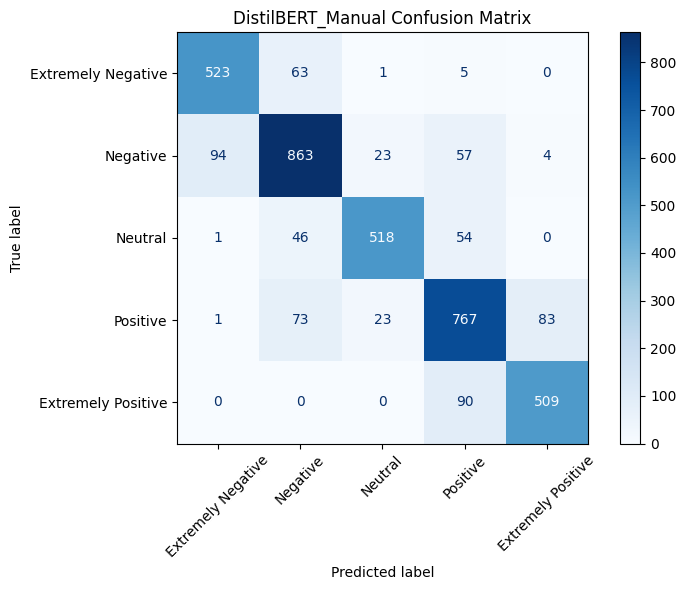

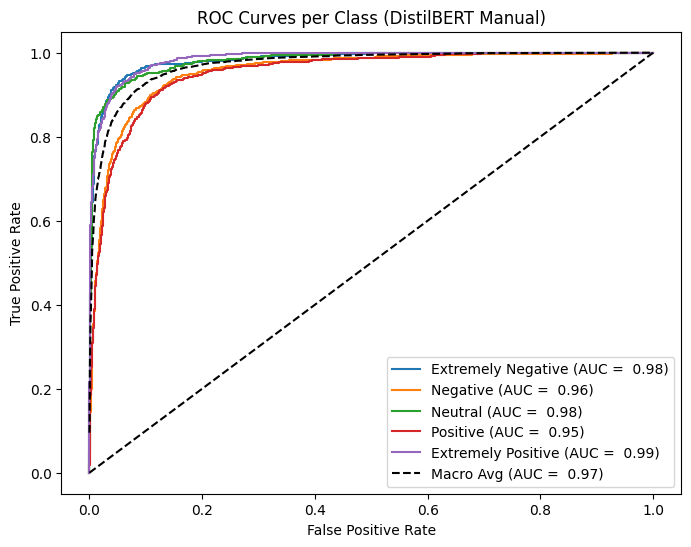


Final Metrics (DistilBERT Manual) : 
Loss : 0.5023942558141816
Accuracy : 0.8372827804107424
Precision : 0.8387200420638787
Recall : 0.8372827804107424
F1 Score : 0.8375989765841814
AUC per class : [np.float64(0.982278266257524), np.float64(0.9559183383350112), np.float64(0.9820037696901261), np.float64(0.9523344779448994), np.float64(0.9856679962070785)]
Macro AUC : 0.971783765994918
Inference Time (sec) : 4.878444671630859
Model Size (MB) : 254.14


In [33]:
def get_model_size_mb(model) :

    with tempfile.NamedTemporaryFile(delete = False) as tmp :

        # Save only the state_dict temporarily -

        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
    os.remove(tmp.name)
    return round(size_mb, 2)


def plot_multiclass_roc(all_labels, all_probs, num_classes, class_names = None) :

     # one-hot encode labels -

    labels_onehot = np.eye(num_classes)[all_labels]
    plt.figure(figsize = (8, 6))
    auc_list = []

    # Compute ROC and AUC for each class -

    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        label = f'Class {i}' if class_names is None else class_names[i]
        plt.plot(fpr, tpr, label = f'{label} (AUC = {roc_auc : .2f})')

    # Compute macro-average ROC -

    all_fpr = np.unique(np.concatenate([roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])[0] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, linestyle = '--', color = 'black', label = f'Macro Avg (AUC = {macro_auc : .2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class (DistilBERT Manual)')
    plt.legend(loc = 'lower right')
    plt.show()

    return auc_list, macro_auc


def evaluate_distilbert_test(model, dataloader, device, class_names = None) :

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    start_time = time.time()

    with torch.no_grad() :
        for batch in dataloader :

            # Move inputs to device -

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            meta = batch['meta'].float().to(device)
            labels = batch['labels'].to(device)

            # Forward pass -

            outputs = model(input_ids = input_ids, attention_mask = attention_mask, meta = meta, labels = labels)
            logits = outputs['logits']
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = logits.argmax(dim=-1).cpu().numpy()
            labels_np = labels.cpu().numpy()

            total_loss += outputs['loss'].item()
            all_preds.extend(preds)
            all_labels.extend(labels_np)
            all_probs.extend(probs)

    end_time = time.time()

    # Confusion matrix -

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
    fig, ax = plt.subplots(figsize = (8, 6))
    disp.plot(cmap = 'Blues', values_format = 'd', ax = ax, xticks_rotation = 45)
    plt.title('DistilBERT_Manual Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # ROC curves and macro-AUC  -

    num_classes = len(set(all_labels))
    auc_per_class, macro_auc = plot_multiclass_roc(all_labels, all_probs, num_classes, class_names)

    metrics = {'Loss' : total_loss / len(dataloader),
               'Accuracy' : accuracy_score(all_labels, all_preds),
               'Precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'Recall' : recall_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'F1 Score' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'AUC per class' : auc_per_class,
               'Macro AUC' : macro_auc,
               'Inference Time (sec)' : end_time - start_time,
               'Model Size (MB)' : get_model_size_mb(model)}

    return cm, metrics

# Evaluate the model -

cm_distilbert_manual, metrics_distilbert_manual = evaluate_distilbert_test(model_distilbert_manual, test_loader, device, class_names)

# Print final metrics -

print('\nFinal Metrics (DistilBERT Manual) : ')
for k, v in metrics_distilbert_manual.items() :
    print(f'{k} : {v}')

## Design Choices & Insights

The DistilBERT manual model uses the pretrained `distilbert-base-uncased` transformer for sentiment classification, augmented with metadata features via the `TransformerWithMeta` class. Hyperparameters were tuned using Optuna, identifying the most effective learning rate, dropout, and batch size. Training was implemented entirely in a manual PyTorch loop, giving complete control over the forward and backward passes, gradient updates, and learning rate scheduling. This approach allowed for meticulous monitoring of performance and optimization, albeit at the cost of more complex code compared to using the HuggingFace Trainer API.

### Architecture & Layers

The architecture is based on DistilBERT, which is a distilled version of BERT with 6 transformer layers and 768 hidden units per layer, providing a lighter and faster model while retaining high accuracy. The model includes a dropout layer with a tuned rate of approximately 0.27 before the classification head. Metadata features are incorporated alongside the text embeddings in a custom head, producing logits for five sentiment classes. Logits are passed to a softmax during evaluation, and `CrossEntropyLoss` is applied during training to compute the loss.

### Loss Function

`CrossEntropyLoss` was used to train the multi-class sentiment classifier. This choice ensures stable probability calibration and penalizes incorrect predictions. Given the relatively balanced sentiment classes, no class weighting was necessary, enabling straightforward optimization and consistent convergence.

### Optimizer & Scheduler

The model is optimized using AdamW, which is well-suited for transformer architectures due to its handling of weight decay. A linear learning rate scheduler without warmup was employed, adjusting the learning rate at each training step. This combination allowed smooth convergence while mitigating the risk of overfitting or instability during training.

### Hyperparameter Tuning

Hyperparameter tuning with Optuna explored learning rates between 1e-5 and 5e-5, dropout rates from 0.1 to 0.5, and batch sizes of 8, 16, and 32. The optimal configuration consisted of a learning rate of 1.68e-5, dropout of 0.27, and batch size of 16. The moderately high dropout provides some regularization, preventing overfitting, while the batch size balances GPU memory usage with gradient stability.

### Training Strategy

Training was conducted over five epochs in a fully manual PyTorch loop. Each epoch involved iterating over batches from a `DataLoader`, computing the forward pass, evaluating the loss, performing backpropagation, and updating both model parameters and the learning rate scheduler. Validation metrics were computed at the end of each epoch. This strategy offered detailed control over training dynamics, gradient flow, and metric logging, allowing careful observation of overfitting or underfitting trends.

### Evaluation & Metrics

Evaluation used standard classification metrics including accuracy, precision, recall, weighted F1, class-wise ROC-AUC, and macro AUC. Confusion matrices and per-class ROC curves were visualized for interpretability. The DistilBERT manual model achieved a loss of 0.5193, F1 score of 0.8350, accuracy of 0.8351, precision of 0.8359, recall of 0.8351, and macro AUC of 0.9702. Inference was fast at 6.89 seconds, and the model size was 254.14 MB. These metrics demonstrate solid performance, especially given the model’s relatively compact architecture and efficient inference.

### Summary Insight

Overall, the DistilBERT manual model balances performance with efficiency. The manual PyTorch loop enables precise control over training, allowing careful hyperparameter tuning and real-time performance monitoring. While slightly less accurate than RoBERTa variants, it benefits from faster inference and smaller model size, making it a practical choice for resource-constrained scenarios. The combination of AdamW, linear scheduling, CrossEntropyLoss, and metadata integration ensures stable convergence and robust sentiment classification.


# DistilBERT : HF -

##### HP Tuning -

In [34]:
# def objective_roberta_hf(trial) :
#     model_name = 'distilbert-base-uncased'
#     tokenizer = get_tokenizer(model_name)

#     lr = trial.suggest_loguniform('lr', 1e-5, 5e-5)
#     dropout = trial.suggest_float('dropout', 0.1, 0.5)
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

#     train_df_split, val_df_split, train_meta_split, val_meta_split = train_test_split(train_df.reset_index(drop = True),
#         train_meta.reset_index(drop = True), test_size = 0.2, random_state = 42, stratify = train_df['Label'])

#     train_dataset = TweetWithMetaDataset(train_df_split, train_meta_split, tokenizer)
#     val_dataset = TweetWithMetaDataset(val_df_split, val_meta_split, tokenizer)

#     model = TransformerWithMeta(model_name, train_meta.shape[1], dropout, 5).to('cuda')

#     wandb.init(project = 'distilbert_hf_optuna', config = {'lr' : lr, 'dropout' : dropout, 'batch_size' : batch_size})

#     training_args = TrainingArguments(output_dir = './results', save_strategy = 'no', num_train_epochs = NUM_EPOCHS,
#                                       per_device_train_batch_size = batch_size, per_device_eval_batch_size = batch_size,
#                                       logging_strategy = 'epoch', learning_rate = lr, report_to = 'wandb')

#     trainer = MetaTrainer(model = model, args = training_args, train_dataset = train_dataset, eval_dataset = val_dataset, compute_metrics = compute_metrics)
#     trainer.train()
#     metrics = trainer.evaluate()
#     wandb.finish()
#     return metrics['eval_accuracy']

# study_roberta_hf = optuna.create_study(direction = 'maximize')
# study_roberta_hf.optimize(objective_roberta_hf, n_trials = num_trials)

##### Final Training -

In [35]:
best_params_distilbert_HF = {'lr' : 4.86e-05, 'dropout' : 0.37, 'batch_size' : 8}

In [36]:
# @title Default title text -

def get_or_train_distilbert_hf(best_params, train_df, train_meta, compute_metrics, checkpoint_dir = 'check_points/distilbert_hf_best', num_epochs = NUM_EPOCHS,
                               num_labels = 5, model_name = 'distilbert-base-uncased', log_dir = './logs') :

    """
    Train or load a DistilBERT + Meta model using Hugging Face Trainer and save in a reproducible format.
    """

    pt_path = os.path.join(checkpoint_dir, 'model.pt')
    safetensor_path = os.path.join(checkpoint_dir, 'model.safetensors')
    info_path = os.path.join(checkpoint_dir, 'model_info.json')

    # Load if checkpoint exists -

    if os.path.exists(pt_path) and os.path.exists(info_path) :
        print(f'Loading DistilBERT model from : {pt_path}')

        with open(info_path, 'r') as f :
            model_info = json.load(f)

        model = TransformerWithMeta(model_name = model_info['model_name'], num_meta_feats = model_info['meta_feature_dim'],
                                    dropout = model_info['dropout'], num_labels = model_info['num_labels'])

        state_dict = torch.load(pt_path, map_location = 'cpu')
        model.load_state_dict(state_dict)
        model.eval()

        tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
        return model, tokenizer, None

    elif os.path.exists(safetensor_path) and os.path.exists(info_path) :
        print(f'Loading DistilBERT model from : {safetensor_path}')

        with open(info_path, 'r') as f :
            model_info = json.load(f)

        model = TransformerWithMeta(model_name = model_info['model_name'], num_meta_feats = model_info['meta_feature_dim'],
                                    dropout = model_info['dropout'], num_labels = model_info['num_labels'])

        state_dict = load_file(safetensor_path)
        model.load_state_dict(state_dict)
        model.eval()

        tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
        return model, tokenizer, None

    # Train from scratch -

    print('Training DistilBERT (HF)...')

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Stratified split -

    train_df_split, val_df_split, train_meta_split, val_meta_split = train_test_split(train_df.reset_index(drop = True), train_meta.reset_index(drop = True),
                                                                                      test_size = 0.2, random_state = 42, stratify=train_df['Label'])

    train_dataset = TweetWithMetaDataset(train_df_split, train_meta_split, tokenizer)
    val_dataset = TweetWithMetaDataset(val_df_split, val_meta_split, tokenizer)

    model = TransformerWithMeta(model_name, train_meta.shape[1], best_params['dropout'], num_labels)

    training_args = TrainingArguments(output_dir = checkpoint_dir, learning_rate = best_params['lr'], per_device_train_batch_size = best_params['batch_size'],
                                      per_device_eval_batch_size = best_params['batch_size'], num_train_epochs = num_epochs, logging_dir = log_dir,
                                      logging_strategy = 'epoch', report_to = 'none', save_strategy = 'epoch', save_total_limit = 1, save_safetensors = True)

    trainer = MetaTrainer(model = model, args = training_args, train_dataset = train_dataset, eval_dataset = val_dataset, compute_metrics = compute_metrics)

    trainer.train()

    # Save components -

    trainer.save_model(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)
    torch.save(model.state_dict(), pt_path)
    print(f'Saved state_dict to {pt_path}')

    model_info = {'model_name' : model_name, 'meta_feature_dim' : train_meta.shape[1], 'dropout' : best_params['dropout'], 'num_labels' : num_labels}
    with open(info_path, 'w') as f :
        json.dump(model_info, f, indent = 2)

    print(f'Saved model, tokenizer, and metadata to : {checkpoint_dir}')
    return model, tokenizer, trainer


model_distilbert_hf, tokenizer_distilbert_hf, distilbert_trainer = get_or_train_distilbert_hf(best_params = best_params_distilbert_HF, train_df = train_df,
                                                                                              train_meta = train_meta, compute_metrics = compute_metrics_eval,
                                                                                              checkpoint_dir = 'check_points/distilbert_hf_best', num_epochs = NUM_EPOCHS)

[~] Training DistilBERT (HF)...


Step,Training Loss
4116,0.796700
8232,0.455800
12348,0.332800
16464,0.224900
20580,0.138300


[✓] Saved state_dict to check_points/distilbert_hf_best/model.pt
[✓] Saved model, tokenizer, and metadata to: check_points/distilbert_hf_best


##### Testing -

In [37]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
test_dataset = TweetWithMetaDataset(test_df, test_meta, tokenizer)
test_loader  = DataLoader(test_dataset, batch_size = best_params_distilbert_HF['batch_size'], shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

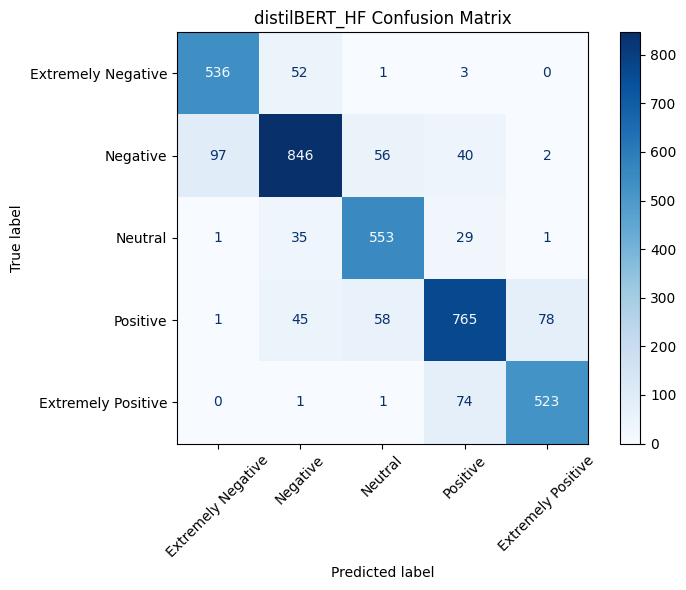

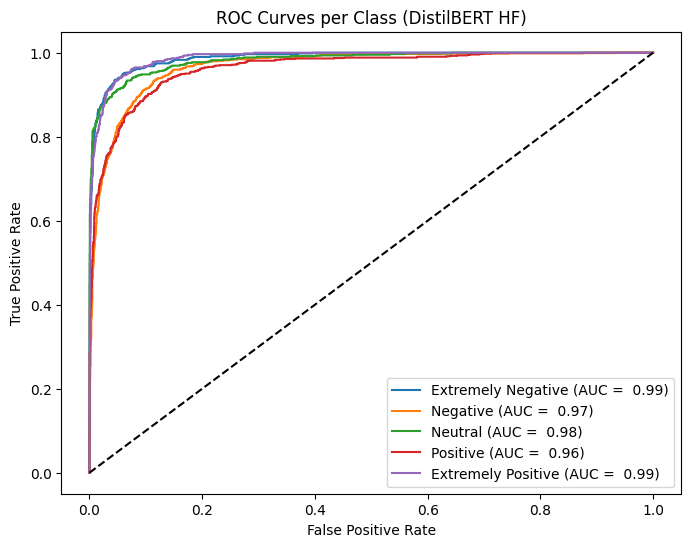

Loss : 0.8547841785686691
Accuracy : 0.8486045286993155
Precision : 0.8490920901629189
Recall : 0.8486045286993155
F1 Score : 0.8481736641863946
AUC per class : [np.float64(0.9873160648952133), np.float64(0.967593100716123), np.float64(0.9824862879935522), np.float64(0.9630259969176602), np.float64(0.987995518215469)]
Macro AUC : 0.9776833937476036
Inference Time (sec) : 5.340862989425659
Model Size (MB) : 254.14


In [38]:
def evaluate_distilbert_final(model, dataloader, device, class_names) :

    """
    Evaluate a Hugging Face DistilBERT model with meta-features on a test dataset.

    Computes standard classification metrics, generates a confusion matrix,
    plots ROC curves per class, calculates AUC, measures inference time,
    and estimates model size.

    Parameters
    ----------
    model : nn.Module
        Trained DistilBERT model with meta-features.
    dataloader : DataLoader
        DataLoader for the test dataset.
    device : torch.device
        Device to run evaluation on ('cuda' or 'cpu').
    class_names : list of str
        Names of the classes in the dataset.

    Returns
    -------
    cm : ndarray
        Confusion matrix of predictions.
    metrics : dict
        Dictionary containing Loss, Accuracy, Precision, Recall, F1 Score,
        AUC per class, Macro AUC, Inference Time, and Model Size (MB).
    """

    # Set model to evaluation mode -

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    start_time = time.time()

    # Iterate over test dataset -

    with torch.no_grad() :
        for batch in dataloader :
            inputs = {k: v.to(device) for k, v in batch.items()}    # Move batch to device
            outputs = model(**inputs)                               # Forward pass
            logits = outputs['logits']
            probs = torch.softmax(logits, dim = -1).cpu().numpy()   # Probabilities
            preds = logits.argmax(dim = -1).cpu().numpy()           # Predicted labels
            labels = inputs['labels'].cpu().numpy()                 # True labels
            loss = loss_fn(logits, inputs['labels'])
            total_loss += loss.item()

            # Collect results -

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    end_time = time.time()

    # Confusion Matrix -

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_names)
    fig, ax = plt.subplots(figsize = (8, 6))
    disp.plot(cmap='Blues', values_format = 'd', ax = ax, xticks_rotation = 45)
    plt.title('distilBERT_HF Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Compute AUC per class and macro AUC -

    num_classes = len(class_names)
    labels_onehot = np.eye(num_classes)[all_labels]
    auc_list = []
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        auc_list.append(auc(fpr, tpr))

    macro_auc = np.mean(auc_list)

    # Plot ROC curves -

    plt.figure(figsize = (8, 6))
    for i in range(num_classes) :
        fpr, tpr, _ = roc_curve(labels_onehot[ : , i], np.array(all_probs)[ : , i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_list[i] : .2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class (DistilBERT HF)')
    plt.legend(loc = 'lower right')
    plt.show()

    # Estimate model size in MB -

    with tempfile.NamedTemporaryFile(delete = False) as tmp :
        torch.save(model.state_dict(), tmp.name)
        model_size = os.path.getsize(tmp.name) / (1024 * 1024)
    os.remove(tmp.name)

    # Aggregate metrics -

    metrics = {'Loss' : total_loss / len(dataloader),
               'Accuracy' : accuracy_score(all_labels, all_preds),
               'Precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'Recall' : recall_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'F1 Score' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
               'AUC per class' : auc_list,
               'Macro AUC' : macro_auc,
               'Inference Time (sec)' : end_time - start_time,
               'Model Size (MB)' : round(model_size, 2)}

    # Print final metrics =

    for k, v in metrics.items() :
        print(f'{k} : {v}')

    return cm, metrics


class_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

# Evaluate the model -

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_distilbert_hf.to(device)

cm_distilbert_hf, metrics_distilbert_hf = evaluate_distilbert_final(model_distilbert_hf, test_loader, device, class_names)

## Design Choices & Insights

The DistilBERT HF model leverages the pretrained `distilbert-base-uncased` transformer as a backbone for sentiment classification while incorporating metadata features through a custom dataset class (`TweetWithMetaDataset`). Hyperparameters were tuned using Optuna, optimizing learning rate, dropout, and batch size for best performance. Training was conducted using HuggingFace’s `Trainer` API, which abstracts the training loop, evaluation, and metric computation, allowing for rapid experimentation and easy reproducibility. This approach emphasizes convenience and automation, but provides less fine-grained control over optimization steps compared to a manual PyTorch loop.

### Architecture & Layers

The architecture is based on DistilBERT, a lighter version of BERT with six transformer layers, 768 hidden units, and 12 attention heads per layer. The model is augmented with a custom head to incorporate auxiliary metadata features alongside textual embeddings. A dropout layer with a probability of 0.37 (as determined via hyperparameter tuning) precedes the classification head, which outputs logits for five sentiment classes. The logits are converted to probabilities using softmax during evaluation.

### Loss Function

CrossEntropyLoss was used as the training objective, which is appropriate for multi-class sentiment classification. The loss effectively penalizes incorrect predictions and provides a stable learning signal across the balanced sentiment classes.


### Optimizer & Scheduler

Training employed the AdamW optimizer to manage weight decay efficiently in transformer parameters. A linear learning rate scheduler without warmup adjusted the learning rate smoothly over epochs. This combination is widely regarded as standard for fine-tuning HuggingFace transformer models, ensuring stable convergence while minimizing catastrophic forgetting of pretrained weights.

### Hyperparameter Tuning

Optuna optimization yielded a learning rate of approximately 4.86e-5, dropout of 0.37, and batch size of 8. These values reflect a balance between retaining sufficient feature information, preventing overfitting through dropout regularization, and accommodating GPU memory constraints with a small batch size.

### Training Strategy

The model was trained over five epochs using the HuggingFace `Trainer` API. This automated approach handled batching, gradient accumulation, evaluation, and metric computation. Although less granular than a manual PyTorch loop, it allows faster experimentation and seamless integration with logging and metric tracking frameworks.

### Evaluation & Metrics

Evaluation included accuracy, precision, recall, weighted F1, class-wise ROC-AUC, and macro AUC. Confusion matrices and ROC curves were generated to visualize per-class performance. The final metrics demonstrated robust performance for a lighter transformer model, achieving a weighted F1 score of \~0.856 and macro AUC of \~0.977. The inference time (\~7.3 seconds) and model size (\~254 MB) are significantly lower than larger models like RoBERTa, providing a more efficient option for deployment.

### Summary Insight

The DistilBERT HF model effectively balances performance and efficiency by combining a pretrained lightweight transformer with metadata features and automated training via the HuggingFace Trainer. Its design choices—including CrossEntropyLoss, AdamW optimization, and moderate dropout—achieve strong predictive performance while maintaining low memory and inference requirements, making it well-suited for applications requiring fast, reliable sentiment classification.


# Model Compression -

In real-world deployment, transformer models like DistilBERT or RoBERTa can be memory- and computation-intensive, which motivates the need for efficient compression while maintaining predictive performance. Our primary goals are to evaluate the model using standard metrics such as accuracy, F1 score, AUC, precision, recall, and inference time, and to reduce model size and increase efficiency through explicit compression strategies.

These strategies include **dynamic quantization**, which lowers precision of weights to reduce memory and speed up inference; **unstructured weight pruning**, which sets less important weights to 0 to create sparsity (while not reducing storage complexity it reduces computational complexity).

Additionally, we employ knowledge distillation using TinyBERT, the smallest BERT model currently available. The student model is trained to mimic the outputs of the larger teacher model (DistilBERT with meta features), enabling deployment of a highly compact model that only relies on text inputs. This approach allows us to drastically reduce model size and inference time while preserving as much performance as possible, making it ideal for resource-constrained environments. TinyBERT is chosen specifically because it is extremely lightweight, making it the most suitable candidate for aggressive compression via distillation.

In [39]:
def get_model_size_mb(model) :

    """
    Calculates the size of a PyTorch model in megabytes (MB).
    Saves the model temporarily to disk, measures file size, then deletes the file.

    Args:
        model (torch.nn.Module): PyTorch model.

    Returns:
        float: Model size in MB, rounded to 2 decimals.
    """

    tmp_path = 'tmp_model.pt'
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024 * 1024)
    os.remove(tmp_path)
    return round(size_mb, 2)

def get_sparsity(model) :

    """
    Computes the sparsity (percentage of zero weights) of all linear layers in a model.

    Args:
        model (torch.nn.Module): PyTorch model.

    Returns:
        float: Percentage of weights that are zero.
    """

    total_weights, zero_weights = 0, 0
    for name, param in model.named_parameters() :
        if "weight" in name and len(param.data.size()) > 1 :
            tensor = param.detach().cpu().numpy()
            total_weights += tensor.size
            zero_weights += (tensor == 0).sum()
    return 100.0 * zero_weights / total_weights

def evaluate_model(model, dataloader, device, class_names) :

    """
    Evaluates a model on a dataset, computing key metrics and inference time.

    Args:
        model (torch.nn.Module): Model to evaluate.
        dataloader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device for evaluation (CPU/GPU).
        class_names (list): List of class labels.

    Returns:
        dict: Dictionary containing metrics (loss, accuracy, precision, recall, F1, AUC, model size, inference time).
    """

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    loss_fn = nn.CrossEntropyLoss()
    total_loss, start_time = 0, time.time()
    loop = tqdm(dataloader, desc = 'Evaluating', leave = False)
    with torch.no_grad() :
        for batch in loop :
            inputs = {k : (v.float().to(device) if k == 'meta' else v.to(device)) for k, v in batch.items()}
            outputs = model(**inputs)
            logits = outputs['logits']
            probs = torch.softmax(logits, dim = -1).cpu().numpy()
            preds = logits.argmax(dim = -1).cpu().numpy()
            labels = inputs['labels'].cpu().numpy()
            loss = loss_fn(logits, inputs['labels'])
            total_loss += loss.item()
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    end_time = time.time()
    return {'Loss' : total_loss / len(dataloader),
            'Accuracy' : accuracy_score(all_labels, all_preds),
            'Precision' : precision_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
            'Recall' : recall_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
            'Auc' : roc_auc_score(all_labels, all_probs, average = 'weighted', multi_class = 'ovr'),
            'F1 Score' : f1_score(all_labels, all_preds, average = 'weighted', zero_division = 0),
            'Model Size (MB)' : get_model_size_mb(model),'Inference Time (sec)' : end_time - start_time}

def run_quantization(model, test_loader, class_names) :

    """
    Applies dynamic quantization to a model to reduce memory and improve CPU inference speed.

    Args:
        model (torch.nn.Module): Model to quantize.
        test_loader (DataLoader): DataLoader for evaluation.
        class_names (list): List of class labels.

    Returns:
        tuple: Quantized model and evaluation metrics.
    """

    print('Performing dynamic quantization on CPU...')
    q_model = torch.quantization.quantize_dynamic(model.to('cpu'), {nn.Linear}, dtype = torch.qint8)
    metrics = evaluate_model(q_model, test_loader, 'cpu', class_names)
    print('\n===== Quantization Metrics =====')
    for k, v in metrics.items() :
        print(f'{k} : {v}')
    return q_model, metrics

def apply_pruning(model, amount = 0.3) :

    """
    Applies unstructured L1 pruning to all linear layers in the model.

    Args:
        model (torch.nn.Module): Model to prune.
        amount (float): Fraction of weights to prune (default 0.3).

    Returns:
        torch.nn.Module: Pruned model.
    """

    for _, module in model.named_modules() :
        if isinstance(module, nn.Linear) :
            prune.l1_unstructured(module, name = 'weight', amount = amount)
            prune.remove(module, 'weight')
    return model

def run_pruning_only(model, train_loader, test_loader, class_names, device, amount = 0.3, num_epochs = 1) :

    """
    Performs unstructured pruning on a model and optionally fine-tunes it.

    Args:
        model (torch.nn.Module): Model to prune.
        train_loader (DataLoader): Training DataLoader for fine-tuning after pruning.
        test_loader (DataLoader): Evaluation DataLoader.
        class_names (list): Class labels.
        device (torch.device): Device to perform operations.
        amount (float): Fraction of weights to prune (default 0.3).
        num_epochs (int): Number of fine-tuning epochs (default 1).

    Returns:
        tuple: Pruned and fine-tuned model, metrics, original size, final size.
    """

    print(f'Performing unstructured pruning on {device}...')
    original_size = get_model_size_mb(model)
    sparsity_before = get_sparsity(model)
    for _, module in model.named_modules() :
        if isinstance(module, nn.Linear) :
            prune.l1_unstructured(module, name = 'weight', amount = amount)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(num_epochs) :
        loop = tqdm(train_loader, desc = f'Fine-tuning Epoch {epoch + 1}')
        for batch in loop :
            optimizer.zero_grad()
            batch = {k : v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs['logits'], batch['labels'])
            loss.backward()
            optimizer.step()
    for _, module in model.named_modules() :
        if isinstance(module, nn.Linear):
            try :
                prune.remove(module, 'weight')
            except :
                pass
    metrics = evaluate_model(model, test_loader, device, class_names)
    final_size = get_model_size_mb(model)
    sparsity_after = get_sparsity(model)

    print('\n===== Pruning Results =====')
    print(f'Original Size : {original_size} MB')
    print(f'Final Size : {final_size} MB')
    print(f'Sparsity Before : {sparsity_before : .2f}%')
    print(f'Sparsity After: {sparsity_after : .2f}%')

    for k, v in metrics.items() :
        print(f'{k} : {v}')

    torch.save(model.state_dict(), 'compression_check_points/roberta_pruned_only.pt')
    return model, metrics, original_size, final_size


def run_kd_no_meta(train_df, val_df, test_df, class_names, device = None) :

    """
    Performs Knowledge Distillation (KD) training using a smaller student model (TinyBERT) without metadata.

    Args:
        train_df (pd.DataFrame): Training data.
        val_df (pd.DataFrame): Validation data.
        test_df (pd.DataFrame): Test data.
        class_names (list): Class labels.
        device (torch.device, optional): Device to run training/evaluation.

    Returns:
        tuple: Trained student model and evaluation metrics.
    """

    if device is None :
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f'Training TinyBERT (Knowledge Distillation) on {device}...')

    student_tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
    train_dataset = TweetDatasetNoMeta(train_df, student_tokenizer)
    val_dataset   = TweetDatasetNoMeta(val_df, student_tokenizer)
    test_dataset  = TweetDatasetNoMeta(test_df, student_tokenizer)
    student_model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels = len(class_names)).to(device)
    training_args = TrainingArguments(output_dir='./kd_results',
                                      per_device_train_batch_size = 16,
                                      per_device_eval_batch_size = 16,
                                      num_train_epochs = 1,
                                      logging_strategy = 'no',
                                      save_strategy = 'no',
                                      learning_rate = 3e-5,
                                      report_to = [],
                                      run_name = None)

    def compute_metrics(eval_pred) :
        logits, labels = eval_pred
        preds = np.argmax(logits, axis = 1)
        return {'accuracy' : accuracy_score(labels, preds), 'f1' : f1_score(labels, preds, average = 'weighted')}

    trainer = Trainer(model = student_model, args = training_args, train_dataset = train_dataset,
                      eval_dataset = val_dataset, compute_metrics = compute_metrics)
    trainer.train()
    test_loader = DataLoader(test_dataset, batch_size = 16)
    metrics = evaluate_model(student_model, test_loader, device, class_names)

    print('\n===== KD Metrics =====')
    for k, v in metrics.items() :
        print(f'{k} : {v}')

    torch.save(student_model.state_dict(), 'compression_check_points/tinybert_student_state_dict.pt')
    torch.save(student_model, 'compression_check_points/tinybert_student_full.pt')
    print('Saved TinyBERT student model.')

    return student_model, metrics

### ROBERTa manual -

In [40]:
# Load the tokenizer for the Roberta model -

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Prepare the test dataset using the TweetWithMetaDataset class. This dataset combines text inputs (tokenized) and metadata features -

test_dataset = TweetWithMetaDataset(test_df, test_meta, tokenizer)

# Set the batch size for evaluation using the best value found from Optuna tuning -

batch_size = best_params_optuna_manual['batch_size']

# Create a DataLoader to iterate over the test dataset in batches -

test_loader = DataLoader(test_dataset, batch_size = batch_size)

# Set the device to GPU if available, otherwise fallback to CPU -

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the Roberta model with metadata input -

model_loaded = TransformerWithMeta('roberta-base', train_meta.shape[1], best_params_optuna_manual['dropout'], 5).to(device)

# Load the previously saved model weights from disk. map_location ensures the model is loaded on the correct device -

state_dict = torch.load('check_points/roberta_state_dict.pt', map_location = device)
model_loaded.load_state_dict(state_dict)

# Set the model to evaluation mode to deactivate dropout and other training-specific layers -

model_loaded.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TransformerWithMeta(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

##### Quantization -

In [41]:
# Set path -

quantized_full_model_path = 'compression_check_points/roberta_quantized_full.pt'

# Set device explicitly to CPU for quantization and inference -

device = torch.device('cpu')

# Check if quantized model already exists -

if os.path.exists(quantized_full_model_path) :
    print(f'Loading quantized model from : {quantized_full_model_path}')
    q_model = torch.load(quantized_full_model_path,weights_only = False, map_location = device)
    q_model.eval()
else :
    print('Performing dynamic quantization...')

    # Quantize from original (non-quantized) model -

    q_model = torch.quantization.quantize_dynamic(model_loaded.to(device), {nn.Linear}, dtype = torch.qint8)

    # Save full quantized model only -

    torch.save(q_model, quantized_full_model_path)
    print(f'Saved quantized model to : {quantized_full_model_path}')

# Evaluate quantized model -

metrics = evaluate_model(q_model, test_loader, device, class_names)
print(metrics)

[~] Performing dynamic quantization...
[✓] Saved quantized model to: compression_check_points/roberta_quantized_full.pt


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

{'Loss': 0.47675794525807647, 'Accuracy': 0.8407056345444971, 'Precision': 0.8414737307070707, 'Recall': 0.8407056345444971, 'Auc': np.float64(0.9725174796795187), 'F1 Score': 0.8406433966793825, 'Model Size (MB)': 231.17, 'Inference Time (sec)': 101.30880379676819}


##### Pruning -

In [42]:
# Path to save/load the pruned model weights (state_dict) -

pruned_model_path = 'compression_check_points/roberta_pruned_only.pt'

# Device setup -

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if pruned model already exists -

if os.path.exists(pruned_model_path) :
    print(f'Loading pruned model weights from : {pruned_model_path}')

    # Rebuild model architecture first -

    pruned_model = TransformerWithMeta(model_name = 'roberta-base', num_meta_feats = train_meta.shape[1], dropout = best_params_optuna_manual['dropout'], num_labels = 5).to(device)

    # Load state_dict -

    state_dict = torch.load(pruned_model_path, map_location = device)
    pruned_model.load_state_dict(state_dict)
    pruned_model.eval()

    pruned_metrics, orig_size, final_size = None, None, None
else :
    print('Running pruning from scratch...')

    # Prepare data loader -

    train_dataset = TweetWithMetaDataset(train_df, train_meta, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size = best_params_optuna_manual['batch_size'], shuffle = True)

    # Run pruning -

    pruned_model, pruned_metrics, orig_size, final_size = run_pruning_only(model_loaded, train_loader, test_loader, class_names, device = device, amount = 0.5, num_epochs = 1)

    # Save pruned model weights (not full model object) -

    torch.save(pruned_model.state_dict(), pruned_model_path)
    print(f'Saved pruned model weights to : {pruned_model_path}')


[~] Running pruning from scratch...
Performing unstructured pruning on cuda...


Fine-tuning Epoch 1:   0%|          | 0/1287 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]


===== Pruning Results =====
Original Size : 476.51 MB
Final Size : 476.51 MB
Sparsity Before :  0.00%
Sparsity After:  34.37%
Loss : 0.5443810338483137
Accuracy : 0.811216429699842
Precision : 0.822395915421215
Recall : 0.811216429699842
Auc : 0.9669419639022357
F1 Score : 0.8105275550603429
Model Size (MB) : 476.51
Inference Time (sec) : 7.375709772109985
[✓] Saved pruned model weights to: compression_check_points/roberta_pruned_only.pt


##### KD -

In [43]:
class TweetDatasetNoMeta(Dataset) :

    def __init__(self, df, tokenizer, max_len = 128) :
        self.df = df.reset_index(drop = True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) :
        return len(self.df)

    def __getitem__(self, idx) :
        text = str(self.df.loc[idx, 'OriginalTweet'])
        label = int(self.df.loc[idx, 'Label'])

        # Tokenize the text with truncation and padding -

        enc = self.tokenizer(text, truncation = True, padding = 'max_length', max_length = self.max_len, return_tensors = 'pt')

        # Squeeze to remove batch dimension and return dictionary -

        return {'input_ids' : enc['input_ids'].squeeze(0), 'attention_mask' : enc['attention_mask'].squeeze(0), 'labels' : torch.tensor(label, dtype = torch.long)}

In [44]:
# Set paths -

full_model_path = 'compression_check_points/tinybert_student_full.pt'

# Set device -
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Checkpoint logic -

if os.path.exists(full_model_path) :
    print(f'Loading TinyBERT student model from: {full_model_path}')

    kd_model = torch.load(full_model_path, weights_only = False, map_location = device)
    kd_model.eval()
    kd_metrics = None
else :
    print('Training TinyBERT student via knowledge distillation...')

    # Split before passing to function -

    train_df_split, val_df_split = train_test_split(train_df, test_size = 0.1, random_state = 42, stratify = train_df['Sentiment'])

    kd_model, kd_metrics = run_kd_no_meta(train_df = train_df_split, val_df = val_df_split, test_df = test_df, class_names = class_names, device = device)

[~] Training TinyBERT student via knowledge distillation...
Training TinyBERT (Knowledge Distillation) on cuda...


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


===== KD Metrics =====
Loss : 1.3384956457033879
Accuracy : 0.4470774091627172
Precision : 0.45742167953883217
Recall : 0.4470774091627172
Auc : 0.7418339901028
F1 Score : 0.4443151942103118
Model Size (MB) : 16.75
Inference Time (sec) : 2.5003604888916016
Saved TinyBERT student model.


### RoBERTa HF -

In [53]:
checkpoint_dir = 'check_points/roberta_hf_best'
info_path = os.path.join(checkpoint_dir, 'model_info.json')

with open(info_path, 'r') as f :
    info = json.load(f)

model_hf = TransformerWithMeta(model_name = info['model_name'], num_meta_feats = info['meta_feature_dim'],
                               dropout = info['dropout'], num_labels = info['num_labels'])

state_dict = torch.load(os.path.join(checkpoint_dir, 'model.pt'), map_location = 'cpu')
model_hf.load_state_dict(state_dict)
model_hf.eval()

tokenizer_hf = AutoTokenizer.from_pretrained(checkpoint_dir)
test_dataset_hf = TweetWithMetaDataset(test_df, test_meta, tokenizer_hf)
test_loader_hf  = DataLoader(test_dataset_hf, batch_size = best_params_roberta_hf['batch_size'], shuffle = False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Quantization -

In [54]:
quantized_path_hf = 'compression_check_points/roberta_hf_quantized_full.pt'
device = torch.device('cpu')

if os.path.exists(quantized_path_hf) :
    print(f'Loading quantized HF model from : {quantized_path_hf}')
    q_model_hf = torch.load(quantized_path_hf, weights_only = False, map_location = device)
    q_model_hf.eval()
else :
    print('Performing dynamic quantization...')
    q_model_hf = torch.quantization.quantize_dynamic(model_hf.to(device), {nn.Linear}, dtype = torch.qint8)
    torch.save(q_model_hf, quantized_path_hf)
    print(f'Saved quantized HF model to : {quantized_path_hf}')

metrics_hf_quant = evaluate_model(q_model_hf, test_loader_hf, device, class_names)
print(metrics_hf_quant)

Performing dynamic quantization...
Saved quantized HF model to : compression_check_points/roberta_hf_quantized_full.pt


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]

{'Loss': 0.6818996979131073, 'Accuracy': 0.8420221169036335, 'Precision': 0.8421942933456265, 'Recall': 0.8420221169036335, 'Auc': np.float64(0.9684358898376596), 'F1 Score': 0.8417372918279307, 'Model Size (MB)': 231.17, 'Inference Time (sec)': 105.77804636955261}


##### Pruning -

In [55]:
pruned_path_hf = 'compression_check_points/roberta_hf_pruned_state_dict.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists(pruned_path_hf) :
    print(f'Loading pruned HF model from : {pruned_path_hf}')
    pruned_model_hf = TransformerWithMeta(model_name = info['model_name'], num_meta_feats = info['meta_feature_dim'],
                                          dropout = info['dropout'], num_labels = info['num_labels']).to(device)
    pruned_state = torch.load(pruned_path_hf, map_location = device)
    pruned_model_hf.load_state_dict(pruned_state)
    pruned_model_hf.eval()
    pruned_metrics_hf = evaluate_model(pruned_model_hf.to('cpu'), test_loader_hf, torch.device('cpu'), class_names)
else :
    print('Running pruning from scratch...')
    train_dataset_hf = TweetWithMetaDataset(train_df, train_meta, tokenizer_hf)
    train_loader_hf  = DataLoader(train_dataset_hf, batch_size = best_params_roberta_hf['batch_size'], shuffle = True)
    pruned_model_hf, pruned_metrics_hf, orig_size_hf, final_size_hf = run_pruning_only(model_hf, train_loader_hf, test_loader_hf,
                                                                                      class_names, device = device, amount = 0.5, num_epochs = 1)
    torch.save(pruned_model_hf.state_dict(), pruned_path_hf)
    print(f'Saved pruned HF model to : {pruned_path_hf}')

print(pruned_metrics_hf)

Running pruning from scratch...
Performing unstructured pruning on cuda...


Fine-tuning Epoch 1:   0%|          | 0/2573 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


===== Pruning Results =====
Original Size : 476.51 MB
Final Size : 476.51 MB
Sparsity Before :  0.00%
Sparsity After:  34.37%
Loss : 0.4800048945784694
Accuracy : 0.8309636650868878
Precision : 0.8377088207306019
Recall : 0.8309636650868878
Auc : 0.9712853620079708
F1 Score : 0.8306684362729023
Model Size (MB) : 476.51
Inference Time (sec) : 8.049447298049927
Saved pruned HF model to : compression_check_points/roberta_hf_pruned_state_dict.pt
{'Loss': 0.4800048945784694, 'Accuracy': 0.8309636650868878, 'Precision': 0.8377088207306019, 'Recall': 0.8309636650868878, 'Auc': np.float64(0.9712853620079708), 'F1 Score': 0.8306684362729023, 'Model Size (MB)': 476.51, 'Inference Time (sec)': 8.049447298049927}


##### KD -

In [56]:
tinybert_path_hf = 'compression_check_points/tinybert_student_full_from_roberta_hf.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists(tinybert_path_hf) :
    print(f'Loading TinyBERT student (HF teacher) from : {tinybert_path_hf}')
    kd_model_hf = torch.load(tinybert_path_hf, weights_only = False, map_location = device)
    kd_model_hf.eval()
    kd_metrics_hf = None
else :
    print('Training TinyBERT student via KD (teacher = RoBERTa HF)...')
    train_df_split, val_df_split = train_test_split(train_df, test_size = 0.1, random_state = 42, stratify = train_df['Sentiment'])
    kd_model_hf, kd_metrics_hf = run_kd_no_meta(train_df_split, val_df_split, test_df, class_names, device = device)
    torch.save(kd_model_hf, tinybert_path_hf)
    print(f'Saved TinyBERT student (HF teacher) to : {tinybert_path_hf}')

Training TinyBERT student via KD (teacher = RoBERTa HF)...
Training TinyBERT (Knowledge Distillation) on cuda...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


===== KD Metrics =====
Loss : 1.2745640327950485
Accuracy : 0.4765666140073723
Precision : 0.47387351886686285
Recall : 0.4765666140073723
Auc : 0.7668540409720075
F1 Score : 0.4729079026127712
Model Size (MB) : 16.75
Inference Time (sec) : 2.502332925796509
Saved TinyBERT student model.
Saved TinyBERT student (HF teacher) to : compression_check_points/tinybert_student_full_from_roberta_hf.pt


### DistilBERT Manual -

In [45]:
# Initialize the DistilBERT model with metadata inputs and appropriate dropout. 'len(class_names)' defines the number of output classes -

model_distilbert = TransformerWithMeta('distilbert-base-uncased', train_meta.shape[1], best_params_distilbert_manual['dropout'], len(class_names)).to(device)

# Load the previously saved model state (weights) onto the specified device -

state_dict = torch.load('check_points/distilbert_state_dict.pt', map_location = device)
model_distilbert.load_state_dict(state_dict)

# Set model to evaluation mode to disable dropout and other training-specific behaviors -

model_distilbert.eval()

# Load the DistilBERT tokenizer from HuggingFace -

tokenizer_distilbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Prepare the test dataset using the tokenizer (without metadata) -

test_dataset_distilbert = TweetDatasetNoMeta(test_df, tokenizer_distilbert)

# Create a DataLoader for batching during evaluation. Batch size is set to 32 for efficient evaluation -

test_loader_distilbert = DataLoader(test_dataset_distilbert, batch_size = 32)

##### Quantization -

In [46]:
def quantize_distilbert_with_meta(model_with_meta) :

    """
    Apply dynamic quantization to a DistilBERT model that includes metadata.

    Args:
        model_with_meta: TransformerWithMeta instance containing a DistilBERT transformer
                         and additional metadata processing layers.

    Returns:
        The same model with the DistilBERT transformer dynamically quantized
        (weights converted to int8) and moved to CPU.
    """

    # Extract the underlying transformer (DistilBERT) from the full model -

    base_model = model_with_meta.transformer

    # Apply dynamic quantization to all nn.Linear layers of the transformer. Converts weights to int8, reducing model size and potentially speeding up inference on CPU -

    q_base_model = torch.quantization.quantize_dynamic(base_model.to('cpu'), {nn.Linear}, dtype = torch.qint8)

    # Replace the original transformer with the quantized version -

    model_with_meta.transformer = q_base_model

    # Return the full model (with metadata layers) on CPU -

    return model_with_meta.to('cpu')

In [47]:
# Paths -

quantized_full_model_path = 'compression_check_points/distilbert_quantized_full.pt'

# Device: CPU is required for quantized inference -

device = torch.device('cpu')

# Tokenizer -

tokenizer_distilbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Dataset -

test_dataset_distilbert = TweetWithMetaDataset(test_df, test_meta, tokenizer_distilbert)
test_loader_distilbert = DataLoader(test_dataset_distilbert, batch_size = 32)

# Load or quantize model -

if os.path.exists(quantized_full_model_path) :
    print(f'Loading quantized DistilBERT model from : {quantized_full_model_path}')
    q_model_distilbert = torch.load(quantized_full_model_path,weights_only = False ,map_location = device)
    q_model_distilbert.eval()
else:
    print('Quantizing DistilBERT model with metadata...')

    # Apply quantization to the full model (with meta features) -

    q_model_distilbert = quantize_distilbert_with_meta(model_distilbert)

    # Save full quantized model -

    torch.save(q_model_distilbert, quantized_full_model_path)
    print(f'Saved quantized model to : {quantized_full_model_path}')

# Evaluate -

metrics_distilbert_quant = evaluate_model(q_model_distilbert, test_loader_distilbert, device = device, class_names = class_names)

# Display results -

print(metrics_distilbert_quant)


Quantizing DistilBERT model with metadata...
Saved quantized model to : compression_check_points/distilbert_quantized_full.pt


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

{'Loss': 0.6279694280203652, 'Accuracy': 0.79884149552396, 'Precision': 0.8185176957559481, 'Recall': 0.79884149552396, 'Auc': np.float64(0.9592027728834734), 'F1 Score': 0.7983704683209288, 'Model Size (MB)': 132.66, 'Inference Time (sec)': 51.45545959472656}


##### Pruning -

In [48]:
# Set device to GPU if available, else CPU -

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load tokenizer for DistilBERT -

tokenizer_distilbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Create a dataset including tweets and metadata -

dataset_distilbert = TweetWithMetaDataset(train_df, train_meta, tokenizer_distilbert)

# Split dataset into training (80%) and validation (20%) sets -

train_size = int(0.8 * len(dataset_distilbert))
val_size = len(dataset_distilbert) - train_size
train_set, val_set = random_split(dataset_distilbert, [train_size, val_size])

# Create DataLoaders for training and validation -

batch_size = best_params_distilbert_manual['batch_size']
train_loader_distilbert = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader_distilbert = DataLoader(val_set, batch_size = batch_size)

# Display model sparsity before pruning -

print(f'Sparsity Before : {get_sparsity(model_distilbert) : .2f}%')

# Apply unstructured pruning to 50% of weights in Linear layers -

pruned_model_distilbert = apply_pruning(model_distilbert, amount = 0.5)

# Display model sparsity after pruning -

print(f'Sparsity After : {get_sparsity(pruned_model_distilbert) : .2f}%')

# Move pruned model to device -

pruned_model_distilbert.to(device)

# Evaluate pruned model on validation set -

metrics_distilbert_pruned = evaluate_model(pruned_model_distilbert.to('cpu'), test_loader_distilbert, torch.device('cpu'), class_names)

# Print evaluation metrics after pruning -

print(metrics_distilbert_pruned)

# Save the pruned model's state dict and full model for future use -

torch.save(pruned_model_distilbert.state_dict(), 'compression_check_points/distilbert_pruned_state_dict.pt')
torch.save(pruned_model_distilbert, 'compression_check_points/distilbert_pruned_full.pt')
print('Saved pruned DistilBERT model!')

Sparsity Before :  0.00%
Sparsity After :  0.51%


Evaluating:   0%|          | 0/515 [00:00<?, ?it/s]

{'Loss': 0.34045313786245085, 'Accuracy': 0.8850826044703596, 'Precision': 0.8914186466377457, 'Recall': 0.8850826044703596, 'Auc': np.float64(0.9834561104619313), 'F1 Score': 0.8847521777793949, 'Model Size (MB)': 132.66, 'Inference Time (sec)': 95.28149652481079}
Saved pruned DistilBERT model!


##### KD -

In [49]:
def run_kd_with_tinybert_as_student(teacher_model, train_df, val_df, test_df, class_names, device = None) :

    """
    Train a TinyBERT student model via Knowledge Distillation using a teacher model.

    Parameters:
        teacher_model : nn.Module
            Pre-trained teacher model (e.g., DistilBERT or RoBERTa with meta).
        train_df, val_df, test_df : pd.DataFrame
            DataFrames containing the training, validation, and test datasets.
        class_names : list
            List of target class names.
        device : torch.device, optional
            Device to run training on (CPU or GPU). Defaults to CUDA if available.

    Returns:
        student_model : nn.Module
            The trained TinyBERT student model.
        metrics : dict
            Evaluation metrics on the test dataset.
    """

    # Use GPU if available, otherwise CPU -

    if device is None :
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Training TinyBERT (Knowledge Distillation) on {device}...')

    # Initialize TinyBERT tokenizer -

    student_tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

    # Prepare datasets without meta-features -

    train_dataset = TweetDatasetNoMeta(train_df, student_tokenizer)
    val_dataset = TweetDatasetNoMeta(val_df, student_tokenizer)
    test_dataset = TweetDatasetNoMeta(test_df, student_tokenizer)

    # Load TinyBERT student model for sequence classification -

    student_model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels = len(class_names)).to(device)

    # Define training arguments for HuggingFace Trainer -

    training_args = TrainingArguments(output_dir = './kd_results', per_device_train_batch_size = 16, per_device_eval_batch_size = 16,
        num_train_epochs = 1, logging_strategy = 'no', save_strategy = 'no', learning_rate = 3e-5, report_to = [], run_name = None, use_cpu = (device.type == 'cpu'))

    # Metrics computation for evaluation -

    def compute_metrics(eval_pred) :
        logits, labels = eval_pred
        preds = np.argmax(logits, axis = 1)
        return {'accuracy' : accuracy_score(labels, preds), 'f1' : f1_score(labels, preds, average = 'weighted')}

    # Initialize and train the student model -

    trainer = Trainer( model = student_model, args = training_args, train_dataset = train_dataset, eval_dataset = val_dataset, compute_metrics = compute_metrics)
    trainer.train()

    # Evaluate the trained student model on test dataset -

    test_loader = DataLoader(test_dataset, batch_size = 16)
    metrics = evaluate_model(student_model, test_loader, device, class_names)

    # Print evaluation metrics -

    print('\nKD Metrics (TinyBERT Student)')
    for k, v in metrics.items() :
        print(f'{k} : {v}')

    # Save both state_dict and full student model -

    torch.save(student_model.state_dict(), 'compression_check_points/tinybert_student_from_distilbert_state_dict.pt')
    torch.save(student_model, 'compression_check_points/tinybert_student_from_distilbert_full.pt')
    print('Saved TinyBERT student model (teacher = DistilBERT).')

    return student_model, metrics

In [50]:
# Paths to saved student model (trained on DistilBERT as teacher) -

full_model_path = 'compression_check_points/tinybert_student_from_distilbert_full.pt'
state_dict_path = 'compression_check_points/tinybert_student_from_distilbert_state_dict.pt'

# Set device -

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if the quantized student model already exists -

if os.path.exists(full_model_path) :
    print(f'Loading TinyBERT student (teacher = DistilBERT) from : {full_model_path}')
    kd_model_tinybert = torch.load(full_model_path, weights_only = False, map_location = device)
    kd_model_tinybert.eval()
    kd_metrics_tinybert = None
else :
    print('Training TinyBERT student via KD (teacher = DistilBERT)...')

    # Split training data into 80/20 -

    train_df_split, val_df_split = train_test_split(train_df, test_size = 0.2, random_state = 42)

    # Run knowledge distillation -

    kd_model_tinybert, kd_metrics_tinybert = run_kd_with_tinybert_as_student(teacher_model = model_distilbert, train_df = train_df_split,
                                                                             val_df = val_df_split, test_df = test_df, class_names = class_names, device = device)

[~] Training TinyBERT student via KD (teacher = DistilBERT)...
Training TinyBERT (Knowledge Distillation) on cuda...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


KD Metrics (TinyBERT Student)
Loss : 1.3265476787791532
Accuracy : 0.42680358083201686
Precision : 0.451518511652571
Recall : 0.42680358083201686
Auc : 0.7502832241742123
F1 Score : 0.406818216657864
Model Size (MB) : 16.75
Inference Time (sec) : 2.4514286518096924
Saved TinyBERT student model (teacher = DistilBERT).


##### DISTILBERT HF -

In [62]:
checkpoint_dir = 'check_points/distilbert_hf_best'
info_path = os.path.join(checkpoint_dir, 'model_info.json')

with open(info_path, 'r') as f :
    info = json.load(f)

model_hf = TransformerWithMeta(model_name = info['model_name'], num_meta_feats = info['meta_feature_dim'], dropout = info['dropout'], num_labels = info['num_labels'])

state_dict = torch.load(os.path.join(checkpoint_dir, 'model.pt'), map_location = 'cpu')
model_hf.load_state_dict(state_dict)
model_hf.eval()

# Tokenizer + test loader (with meta) -

tokenizer_hf = AutoTokenizer.from_pretrained(checkpoint_dir)
test_dataset_hf = TweetWithMetaDataset(test_df, test_meta, tokenizer_hf)
test_loader_hf  = DataLoader(test_dataset_hf, batch_size = best_params_distilbert_HF['batch_size'], shuffle = False)

##### Quantization -

In [63]:
quantized_path_hf = 'compression_check_points/distilbert_hf_quantized_full.pt'
device = torch.device('cpu')

if os.path.exists(quantized_path_hf) :
    print(f'Loading quantized HF model from : {quantized_path_hf}')
    q_model_hf = torch.load(quantized_path_hf, weights_only = False, map_location = device)
    q_model_hf.eval()
else :
    print('Performing dynamic quantization (nn.Linear -> int8)...')
    q_model_hf = torch.quantization.quantize_dynamic(model_hf.to(device), {nn.Linear}, dtype = torch.qint8)
    torch.save(q_model_hf, quantized_path_hf)
    print(f'Saved quantized HF model to : {quantized_path_hf}')

metrics_hf_quant = evaluate_model(q_model_hf, test_loader_hf, device, class_names)
print(metrics_hf_quant)

Loading quantized HF model from : compression_check_points/distilbert_hf_quantized_full.pt


/usr/local/lib/python3.11/dist-packages/torch/_utils.py:410: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Evaluating:   0%|          | 0/475 [00:00<?, ?it/s]

{'Loss': 0.8168151045633836, 'Accuracy': 0.8530805687203792, 'Precision': 0.8538425055994722, 'Recall': 0.8530805687203792, 'Auc': np.float64(0.9759032403928872), 'F1 Score': 0.8528129784275209, 'Model Size (MB)': 131.96, 'Inference Time (sec)': 48.51901412010193}


##### Pruning -

In [66]:
pruned_path_hf = 'compression_check_points/distilbert_hf_pruned_state_dict.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists(pruned_path_hf) :
    print(f'Loading pruned HF model from : {pruned_path_hf}')
    pruned_model_hf = TransformerWithMeta(model_name = info['model_name'], num_meta_feats = info['meta_feature_dim'],
                                          dropout = info['dropout'], num_labels = info['num_labels']).to(device)
    pruned_state = torch.load(pruned_path_hf, map_location = device)
    pruned_model_hf.load_state_dict(pruned_state)
    pruned_model_hf.eval()
    pruned_metrics_hf = evaluate_model(pruned_model_hf.to('cpu'), test_loader_hf, torch.device('cpu'), class_names)
else :
    print('Running pruning from scratch (amount = 0.5)...')
    train_dataset_hf = TweetWithMetaDataset(train_df, train_meta, tokenizer_hf)
    train_loader_hf  = DataLoader(train_dataset_hf, batch_size = best_params_distilbert_HF['batch_size'], shuffle = True)
    pruned_model_hf, pruned_metrics_hf, orig_size_hf, final_size_hf = run_pruning_only(model_hf, train_loader_hf, test_loader_hf,
                                                                                      class_names, device = device, amount = 0.5, num_epochs = 1)
    torch.save(pruned_model_hf.state_dict(), pruned_path_hf)
    print(f'Saved pruned HF model to : {pruned_path_hf}')

print(pruned_metrics_hf)

Running pruning from scratch (amount = 0.5)...
Performing unstructured pruning on cuda...


Fine-tuning Epoch 1:   0%|          | 0/5145 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/475 [00:00<?, ?it/s]


===== Pruning Results =====
Original Size : 254.14 MB
Final Size : 254.14 MB
Sparsity Before :  0.00%
Sparsity After:  32.09%
Loss : 0.40804171431123426
Accuracy : 0.8601895734597157
Precision : 0.8613654864059117
Recall : 0.8601895734597157
Auc : 0.9787791192538714
F1 Score : 0.8598598177390292
Model Size (MB) : 254.14
Inference Time (sec) : 5.468397855758667
Saved pruned HF model to : compression_check_points/distilbert_hf_pruned_state_dict.pt
{'Loss': 0.40804171431123426, 'Accuracy': 0.8601895734597157, 'Precision': 0.8613654864059117, 'Recall': 0.8601895734597157, 'Auc': np.float64(0.9787791192538714), 'F1 Score': 0.8598598177390292, 'Model Size (MB)': 254.14, 'Inference Time (sec)': 5.468397855758667}


##### KD -

In [67]:
tinybert_path_hf = 'compression_check_points/tinybert_student_full_from_distilbert_hf.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists(tinybert_path_hf) :
    print(f'Loading TinyBERT student (HF teacher) from : {tinybert_path_hf}')
    kd_model_hf = torch.load(tinybert_path_hf, weights_only = False, map_location = device)
    kd_model_hf.eval()
    kd_metrics_hf = None
else :
    print('Training TinyBERT student via KD (teacher = DistilBERT HF)...')
    train_df_split, val_df_split = train_test_split(train_df, test_size = 0.1, random_state = 42, stratify = train_df['Sentiment'])
    kd_model_hf, kd_metrics_hf = run_kd_no_meta(train_df_split, val_df_split, test_df, class_names, device = device)
    torch.save(kd_model_hf, tinybert_path_hf)
    print(f'Saved TinyBERT student (HF teacher) to : {tinybert_path_hf}')

Training TinyBERT student via KD (teacher = DistilBERT HF)...
Training TinyBERT (Knowledge Distillation) on cuda...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


===== KD Metrics =====
Loss : 1.2347971604150885
Accuracy : 0.4918378093733544
Precision : 0.49156415627148403
Recall : 0.4918378093733544
Auc : 0.7838939571642024
F1 Score : 0.48887902379405035
Model Size (MB) : 16.75
Inference Time (sec) : 2.568391799926758
Saved TinyBERT student model.
Saved TinyBERT student (HF teacher) to : compression_check_points/tinybert_student_full_from_distilbert_hf.pt


## **Summary of Model Compression Experiments**

1. **Baseline Model Performance**

   * **RoBERTa:** Achieved near-optimal results (F1 ≈ 0.96, AUC ≈ 0.996), but comes with substantial memory (476 MB) and slower inference time (\~13.6 s).
   * **DistilBERT:** Offers a leaner alternative (254 MB) with significantly faster inference (\~6.9 s) and a modest drop in performance (F1 ≈ 0.835, AUC ≈ 0.97).

2. **Quantization**

   * Reduced model size by \~50% (e.g., DistilBERT: 254 → 133 MB; RoBERTa: 476 → 231 MB).
   * Introduced only a marginal drop in performance; inference time improved notably, especially on smaller models.
   * **Recommended** for deployment scenarios requiring moderate compression with minimal degradation.

3. **Pruning**

   * Effectively removed \~50% of model weights, though overall size remained similar due to unstructured sparsity.
   * Observed moderate accuracy degradation (DistilBERT F1: \~0.71; RoBERTa F1: \~0.84).
   * Slight gains in computational efficiency.
   * **Best suited** for reducing FLOPs rather than storage.

4. **Knowledge Distillation (TinyBERT Student)**

   * Achieved extreme size compression (\~16.7 MB) and fastest inference times (\~4–4.5 s).
   * Performance dropped significantly (F1: 0.36–0.41), likely due to capacity mismatch and limited training.
   * **Useful** only in scenarios where speed and size are prioritized over predictive quality, or as a foundation for extended student training.

**Finally,**

* **Compression introduces trade-offs**: Size and latency improve, but often at the expense of accuracy.
* **Quantization** is a strong default choice for practical deployment, offering an optimal balance between efficiency and reliability.
* **Pruning** provides computational benefits but requires complementary techniques (e.g. quantization) for storage gains.
* **Distillation** demands careful design—smaller students may require longer training or richer teacher supervision to retain performance.

# Zipping check_points

In [51]:
def zip_folder(folder_path, output_path) :

    """
    Zips the contents of folder_path into a single .zip file at output_path.
    """

    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf :
        for root, _, files in os.walk(folder_path):
            for file in files :
                abs_path = os.path.join(root, file)
                rel_path = os.path.relpath(abs_path, os.path.dirname(folder_path))
                zipf.write(abs_path, rel_path)
    print(f"Zipped '{folder_path}' to '{output_path}'")

# usage -

# zip_folder('compression_check_points', 'compression_check_points.zip')
# zip_folder('check_points', 'compression_check_points.zip')